In [31]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
import warnings
warnings.filterwarnings("ignore")

workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
for ii,subject in enumerate(subjects):
    # try:
    #     GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    # except:
    #     pass
    t=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
            # GreedyBestAcc[ii,len_topN] = di['bestAcc']
            
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[subject]
    bestID[subject] = numberOfROIs[subject][np.where(t==np.nanmax(t))[0][0]] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    # if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
    np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)

'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject,testRun=6):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []

    run=testRun
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}


    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y)*1==1)[0][0]
    #     Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
    #     # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
    #     return np.asarray(Evidence)

    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y)*1==1)[0][0]
    #     p = clf.predict_proba(X)[:,ID]
    #     BX=np.log(p/(1-p))
    #     return BX

    def classifierProb(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        p = clf.predict_proba(X)[:,ID]
        return p
    def logit(p):
        return np.log(p/(1-p))
    A_ID = (META['label']=='bed')
    X = FEAT[A_ID]


    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"

    store="\n"
    print("floor")
    # D evidence for AD_clf when A is presented.
    Y = 'bench'
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_D_evidence = classifierProb(AD_clf,X,Y)
    evidence_floor = np.mean(AD_D_evidence)
    print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # C evidence for AC_clf when A is presented.
    Y = 'table'
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_C_evidence = classifierProb(AC_clf,X,Y)
    evidence_floor = np.mean(AC_C_evidence)
    print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # D evidence for CD_clf when A is presented.
    Y = 'bench'
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_D_evidence = classifierProb(CD_clf,X,Y)
    evidence_floor = np.mean(CD_D_evidence)
    print(f"D evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor}"

    # C evidence for CD_clf when A is presented.
    Y = 'table'
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_C_evidence = classifierProb(CD_clf,X,Y)
    evidence_floor = np.mean(CD_C_evidence)
    print(f"C evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor}"


    print("ceil")
    store=store+"\n"+"ceil"
    # evidence_ceil  is A evidence in AC and AD classifier
    Y = 'bed'
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_A_evidence = classifierProb(AC_clf,X,Y)
    evidence_ceil1 = AC_A_evidence
    print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    Y = 'bed'
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_A_evidence = classifierProb(AD_clf,X,Y)
    evidence_ceil2 = AD_A_evidence
    print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # evidence_ceil = np.mean(evidence_ceil1)
    # evidence_ceil = np.mean(evidence_ceil2)
    evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    print(f"evidence_ceil={evidence_ceil}")
    store=store+"\n"+f"evidence_ceil={evidence_ceil}"
    ceil,floor=logit(evidence_ceil),logit(evidence_floor)
    mu = (ceil+floor)/2
    sig = (ceil-floor)/2.3548
    print(f"floor={floor}, ceil={ceil}")
    print(f"mu={mu}, sig={sig}")

    store=store+"\n"+f"floor={floor}, ceil={ceil}"
    store=store+"\n"+f"mu={mu}, sig={sig}"




    BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    Y = 'chair'
    # imcodeDict={
    # 'A': 'bed',
    # 'B': 'chair',
    # 'C': 'table',
    # 'D': 'bench'}
    print(f"classifierProb(BC_clf,FEAT,Y)={classifierProb(BC_clf,FEAT,Y)}")
    print(f"classifierProb(BD_clf,FEAT,Y)={classifierProb(BD_clf,FEAT,Y)}")





    # # convert item colume to label colume
    # imcodeDict={
    # 'A': 'bed',
    # 'B': 'chair',
    # 'C': 'table',
    # 'D': 'bench'}
    def testMorphParamFor(A): #A='bed''chair'...
        A_ID = (META['label']==A)
        X = FEAT[A_ID]


        # 这里的X是选择的testRun里面的所有的展示A的trials
        BC_B_evidence = classifierProb(BC_clf,X,Y)
        BD_B_evidence = classifierProb(BD_clf,X,Y)
        print(f"BC_B_evidence={BC_B_evidence}")
        print(f"BD_B_evidence={BD_B_evidence}")
        B_evidence = (BC_B_evidence+BD_B_evidence)/2
        print(f"B_evidence={B_evidence}")
        print(f"mu={mu}, sig={sig}")
        



        def gaussian(x, mu, sig):
            # mu and sig is determined before each neurofeedback session using 2 recognition runs.
            return np.round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (-∞,∞) -> [1,19]
        morphParam=np.mean(gaussian(B_evidence, mu, sig))
        # B_evidences.append(B_evidence)
        print(f"morphParam={morphParam}")
        return f"morphParam for {A} = {morphParam}"

    store=store+"\n"+testMorphParamFor('bed')
    store=store+"\n"+testMorphParamFor('chair')
    store=store+"\n"+testMorphParamFor('table')
    store=store+"\n"+testMorphParamFor('bench')

    return evidence_floor, evidence_ceil,store



'''
load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
''' 

subject=subjects[0]
'''
purpose: 
    train offline models

steps:
    load preprocessed and aligned behavior and brain data 
    select data with the wanted pattern like AB AC AD BC BD CD 
    train correspondng classifier and save the classifier performance and the classifiers themselves.

'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression

def gaussian(x, mu, sig):
    # mu and sig is determined before each neurofeedback session using 2 recognition runs.
    return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

def jitter(size,const=0):
    jit = np.random.normal(0+const, 0.05, size)
    X = np.zeros((size))
    X = X + jit
    return X

def other(target):
    other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
    return other_objs

def red_vox(n_vox, prop=0.1):
    return int(np.ceil(n_vox * prop))

def get_inds(X, Y, pair, testRun=None):

    inds = {}

    # return relative indices
    if testRun:
        trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
    else:
        trainIX = Y.index[(Y['label'].isin(pair))]

    # pull training and test data
    trainX = X[trainIX]
    trainY = Y.iloc[trainIX].label

    # Main classifier on 5 runs, testing on 6th
    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                            multi_class='multinomial').fit(trainX, trainY)
    B = clf.coef_[0]  # pull betas

    # retrieve only the first object, then only the second object
    if testRun:
        obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
        obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
    else:
        obj1IX = Y.index[(Y['label'] == pair[0])]
        obj2IX = Y.index[(Y['label'] == pair[1])]

    # Get the average of the first object, then the second object
    obj1X = np.mean(X[obj1IX], 0)
    obj2X = np.mean(X[obj2IX], 0)

    # Build the importance map
    mult1X = obj1X * B
    mult2X = obj2X * B

    # Sort these so that they are from least to most important for a given category.
    sortmult1X = mult1X.argsort()[::-1]
    sortmult2X = mult2X.argsort()

    # add to a dictionary for later use
    inds[clf.classes_[0]] = sortmult1X
    inds[clf.classes_[1]] = sortmult2X

    return inds

if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
else:
    main_dir='/Users/kailong/Desktop/rtTest'

working_dir=main_dir
os.chdir(working_dir)

objects = ['bed', 'bench', 'chair', 'table']


if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"

# print('mask dimensions: {}'. format(mask.shape))
# print('number of voxels in mask: {}'.format(np.sum(mask)))
phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
print(f"np.sum(chosenMask)={np.sum(chosenMask)}")
# Compile preprocessed data and corresponding indices
metas = []
for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]

    # Build the path for the preprocessed functional data
    this4d = funcdata.format(run=run, phase=phase, sub=subject)

    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]

    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)

    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()

    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num] # here shape is from (94, 94, 72, 240) to (80, 94, 94, 72)
    features = np.array(features)
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
    features = normalize(features)
    # features = np.expand_dims(features, 0)

    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t if run==1 else pd.concat([behav_data,t])

    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()
brain_data = runs
print(brain_data.shape)
print(behav_data.shape)
FEAT=brain_data
print(f"FEAT.shape={FEAT.shape}")
META=behav_data

def Class(brain_data,behav_data):
    accs = []
    for run in range(1,7):
        trainIX = behav_data['run_num']!=int(run)
        testIX = behav_data['run_num']==int(run)

        trainX =  brain_data[trainIX]
        trainY =  behav_data.iloc[np.asarray(trainIX)].label

        testX =  brain_data[testIX]
        testY =  behav_data.iloc[np.asarray(testIX)].label

        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)

        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    accs
    return np.mean(accs)
accs=Class(brain_data,behav_data)
print(f"new trained 4 way classifier accuracy={accs}")


# convert item colume to label colume
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}

# Which run to use as test data (leave as None to not have test data)
accs_rotation_container={}
evidence_rotation_container={}
for testRun in range(1,7):
    # testRun = 6 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

    # Decide on the proportion of crescent data to use for classification
    include = 1
    objects = ['bed', 'bench', 'chair', 'table']
    allpairs = itertools.combinations(objects,2)
    accs={}
    # Iterate over all the possible target pairs of objects
    for pair in allpairs:
        # Find the control (remaining) objects for this pair
        altpair = other(pair)

        # pull sorted indices for each of the critical objects, in order of importance (low to high)
        # inds = get_inds(FEAT, META, pair, testRun=testRun)

        # Find the number of voxels that will be left given your inclusion parameter above
        # nvox = red_vox(FEAT.shape[1], include)

        for obj in pair:
            # foil = [i for i in pair if i != obj][0]
            for altobj in altpair:

                # establish a naming convention where it is $TARGET_$CLASSIFICATION
                # Target is the NF pair (e.g. bed/bench)
                # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

                # Pull the relevant inds from your previously established dictionary 
                # obj_inds = inds[obj]

                # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                # if testRun:
                #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                # else:
                #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
                #     testIX = META.index[(META['label'].isin([obj, altobj]))]
                # # pull training and test data
                # trainX = FEAT[trainIX]
                # testX = FEAT[testIX]
                # trainY = META.iloc[trainIX].label
                # testY = META.iloc[testIX].label

                # print(f"obj={obj},altobj={altobj}")
                # print(f"unique(trainY)={np.unique(trainY)}")
                # print(f"unique(testY)={np.unique(testY)}")
                # assert len(np.unique(trainY))==2

                # for testRun in range(6):
                if testRun:
                    trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                    testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
                else:
                    trainIX = ((META['label']==obj) + (META['label']==altobj))
                    testIX = ((META['label']==obj) + (META['label']==altobj))
                # pull training and test data
                trainX = FEAT[trainIX]
                testX = FEAT[testIX]
                trainY = META.iloc[np.asarray(trainIX)].label
                testY = META.iloc[np.asarray(testIX)].label

                # print(f"obj={obj},altobj={altobj}")
                # print(f"unique(trainY)={np.unique(trainY)}")
                # print(f"unique(testY)={np.unique(testY)}")
                assert len(np.unique(trainY))==2

                # # If you're selecting high-importance features, this bit handles that
                # if include < 1:
                #     trainX = trainX[:, obj_inds[-nvox:]]
                #     testX = testX[:, obj_inds[-nvox:]]

                # Train your classifier
                clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                        multi_class='multinomial').fit(trainX, trainY)


                model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
                mkdir(model_folder)
                # Save it for later use
                joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))

                # Monitor progress by printing accuracy (only useful if you're running a test set)
                acc = clf.score(testX, testY)
                # print(naming, acc)
                accs[naming]=acc
    accs_rotation_container[testRun] = accs
    evidence_rotation_container[testRun] = morphingTarget(subject,testRun=testRun)
# for testRun in range(1,7):
#     t=np.mean(list(accs_rotation_container[testRun].values()))
#     print(f"testRun {testRun} mean testing accracy={t}")
#     print(evidence_rotation_container[testRun][2])
def getString(string,searchFor,end):
    return string.split(searchFor)[1].split(end)[0]
# getString(string,searchFor)

floors=[]
ceils=[]
for testRun in range(1,7):
    t=np.mean(list(accs_rotation_container[testRun].values()))
    print(f"testRun {testRun} mean testing accracy={t}")
    # print(evidence_rotation_container[testRun][2])
    t=np.float(getString(evidence_rotation_container[testRun][2],"floor=",","))
    print("floor=",t)
    floors.append(t)

    t=np.float(getString(evidence_rotation_container[testRun][2],"ceil=","\n"))
    print("ceiling=",t)
    ceils.append(t)
    print()
    print()
print(np.mean(floors))
print(np.mean(ceils))


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
np.sum(chosenMask)=4927
1--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
(480, 4927)
(480, 2)
FEAT.shape=(480, 4927)
new trained 4 way classifier accuracy=0.3520833333333333
1--LENGTH OF TR: 80
shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=0.4301477965026425
C evidence for AC_clf when A is presented=0.44626260592632655
D evidence for CD_clf when A is presented=0.43046667837478136
C evi

3--LENGTH OF TR: 80
shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=0.4473517957820715
C evidence for AC_clf when A is presented=0.4852002139706416
D evidence for CD_clf when A is presented=0.4605165608931128
C evidence for CD_clf when A is presented=0.5394834391068871
ceil
A evidence in AC_clf when A is presented=0.5147997860293584
A evidence in AD_clf when A is presented=0.5526482042179285
evidence_ceil=0.5337239951236434
floor=0.1582632695833372, ceil=0.13510109833967454
mu=0.14668218396150587, sig=-0.009836152218304167
classifierProb(BC_clf,FEAT,Y)=[0.20356662 0.34440413 0.00331972 0.34055301 0.42100174 0.9030117
 0.43342672 0.26089377 0.67186072 0.03100885 0.36397097 0.89644102
 0.83602425 0.5578651  0.69585149 0.92460581 0.83893906 0.17770192
 0.09953022 0.45368758 0.94224712 0.08915348 0.80275503 0.7666801
 0.08336152 0.52321432 0.23280764 0.4591914  0.2812699  0.81370899
 0.81284574

5--LENGTH OF TR: 80
shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=0.4040733235133061
C evidence for AC_clf when A is presented=0.4936630601375779
D evidence for CD_clf when A is presented=0.44997249014798885
C evidence for CD_clf when A is presented=0.5500275098520112
ceil
A evidence in AC_clf when A is presented=0.5063369398624221
A evidence in AD_clf when A is presented=0.5959266764866938
evidence_ceil=0.551131808174558
floor=0.20078184699721244, ceil=0.20524471159658314
mu=0.20301327929689778, sig=0.001895220230750256
classifierProb(BC_clf,FEAT,Y)=[9.40103135e-01 9.98224821e-01 9.84864966e-01 9.98939794e-01
 9.92660607e-01 9.92017170e-01 9.67568778e-01 9.69422755e-01
 9.02790106e-01 9.87097389e-01 8.56867449e-01 9.54850585e-01
 9.75591188e-01 9.03291776e-01 9.80159765e-01 5.16429194e-01
 8.28670804e-01 9.57324008e-01 2.18726136e-01 9.56450618e-01
 1.54202946e-01 6.12409557e-01 5.802533

In [32]:

floors=[]
ceils=[]
for testRun in range(1,7):
    t=np.mean(list(accs_rotation_container[testRun].values()))
    print(f"testRun {testRun} mean testing accracy={t}")
    # print(evidence_rotation_container[testRun][2])
    t=np.float(getString(evidence_rotation_container[testRun][2],"floor=",","))
    print("floor=",t)
    floors.append(t)

    t=np.float(getString(evidence_rotation_container[testRun][2],"ceil=","\n"))
    print("ceiling=",t)
    ceils.append(t)
    print()
    print()
print(np.mean(floors))
print(np.mean(ceils))


testRun 1 mean testing accracy=0.5583333333333335
floor= 0.27994737276911297
ceiling= 0.5617947987855155


testRun 2 mean testing accracy=0.5125
floor= -0.1290902928161224
ceiling= 0.48111248929179695


testRun 3 mean testing accracy=0.5333333333333333
floor= 0.1582632695833372
ceiling= 0.5337239951236434


testRun 4 mean testing accracy=0.5458333333333333
floor= -0.26463689904676585
ceiling= 0.5512983143808935


testRun 5 mean testing accracy=0.6
floor= 0.20078184699721244
ceiling= 0.551131808174558


testRun 6 mean testing accracy=0.5291666666666667
floor= 0.06546476052975952
ceiling= 0.523272218556656


0.051788343002755644
0.5337222707188438


In [33]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
import warnings
warnings.filterwarnings("ignore")

workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
for ii,subject in enumerate(subjects):
    # try:
    #     GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    # except:
    #     pass
    t=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
            # GreedyBestAcc[ii,len_topN] = di['bestAcc']
            
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[subject]
    bestID[subject] = numberOfROIs[subject][np.where(t==np.nanmax(t))[0][0]] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    # if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
    np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)

'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject,testRun=6):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []

    run=testRun
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}


    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y)*1==1)[0][0]
    #     Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
    #     # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
    #     return np.asarray(Evidence)

    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y)*1==1)[0][0]
    #     p = clf.predict_proba(X)[:,ID]
    #     BX=np.log(p/(1-p))
    #     return BX

    def classifierProb(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        p = clf.predict_proba(X)[:,ID]
        return p
    def logit(p):
        return np.log(p/(1-p))
    A_ID = (META['label']=='bed')
    X = FEAT[A_ID]


    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"

    store="\n"
    print("floor")
    # D evidence for AD_clf when A is presented.
    Y = 'bench'
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_D_evidence = classifierProb(AD_clf,X,Y)
    evidence_floor = np.mean(AD_D_evidence)
    print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # C evidence for AC_clf when A is presented.
    Y = 'table'
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_C_evidence = classifierProb(AC_clf,X,Y)
    evidence_floor = np.mean(AC_C_evidence)
    print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # D evidence for CD_clf when A is presented.
    Y = 'bench'
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_D_evidence = classifierProb(CD_clf,X,Y)
    evidence_floor = np.mean(CD_D_evidence)
    print(f"D evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor}"

    # C evidence for CD_clf when A is presented.
    Y = 'table'
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_C_evidence = classifierProb(CD_clf,X,Y)
    evidence_floor = np.mean(CD_C_evidence)
    print(f"C evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor}"


    print("ceil")
    store=store+"\n"+"ceil"
    # evidence_ceil  is A evidence in AC and AD classifier
    Y = 'bed'
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_A_evidence = classifierProb(AC_clf,X,Y)
    evidence_ceil1 = AC_A_evidence
    print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    Y = 'bed'
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_A_evidence = classifierProb(AD_clf,X,Y)
    evidence_ceil2 = AD_A_evidence
    print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # evidence_ceil = np.mean(evidence_ceil1)
    # evidence_ceil = np.mean(evidence_ceil2)
    evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    print(f"evidence_ceil={evidence_ceil}")
    store=store+"\n"+f"evidence_ceil={evidence_ceil}"
    ceil,floor=logit(evidence_ceil),logit(evidence_floor)
    mu = (ceil+floor)/2
    sig = (ceil-floor)/2.3548
    print(f"floor={floor}, ceil={ceil}")
    print(f"mu={mu}, sig={sig}")

    store=store+"\n"+f"floor={floor}, ceil={ceil}"
    store=store+"\n"+f"mu={mu}, sig={sig}"




    BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    Y = 'chair'
    # imcodeDict={
    # 'A': 'bed',
    # 'B': 'chair',
    # 'C': 'table',
    # 'D': 'bench'}
    print(f"classifierProb(BC_clf,FEAT,Y)={classifierProb(BC_clf,FEAT,Y)}")
    print(f"classifierProb(BD_clf,FEAT,Y)={classifierProb(BD_clf,FEAT,Y)}")





    # # convert item colume to label colume
    # imcodeDict={
    # 'A': 'bed',
    # 'B': 'chair',
    # 'C': 'table',
    # 'D': 'bench'}
    def testMorphParamFor(A): #A='bed''chair'...
        A_ID = (META['label']==A)
        X = FEAT[A_ID]


        # 这里的X是选择的testRun里面的所有的展示A的trials
        BC_B_evidence = classifierProb(BC_clf,X,Y)
        BD_B_evidence = classifierProb(BD_clf,X,Y)
        print(f"BC_B_evidence={BC_B_evidence}")
        print(f"BD_B_evidence={BD_B_evidence}")
        B_evidence = (BC_B_evidence+BD_B_evidence)/2
        print(f"B_evidence={B_evidence}")
        print(f"mu={mu}, sig={sig}")
        



        def gaussian(x, mu, sig):
            # mu and sig is determined before each neurofeedback session using 2 recognition runs.
            return np.round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (-∞,∞) -> [1,19]
        morphParam=np.mean(gaussian(B_evidence, mu, sig))
        # B_evidences.append(B_evidence)
        print(f"morphParam={morphParam}")
        return f"morphParam for {A} = {morphParam}"

    store=store+"\n"+testMorphParamFor('bed')
    store=store+"\n"+testMorphParamFor('chair')
    store=store+"\n"+testMorphParamFor('table')
    store=store+"\n"+testMorphParamFor('bench')

    return evidence_floor, evidence_ceil,store



'''
load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
''' 
def minimalClass(subject):
    # subject=subjects[1]
    '''
    purpose: 
        train offline models

    steps:
        load preprocessed and aligned behavior and brain data 
        select data with the wanted pattern like AB AC AD BC BD CD 
        train correspondng classifier and save the classifier performance and the classifiers themselves.

    '''

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import joblib
    import nibabel as nib
    import itertools
    from sklearn.linear_model import LogisticRegression

    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

    def jitter(size,const=0):
        jit = np.random.normal(0+const, 0.05, size)
        X = np.zeros((size))
        X = X + jit
        return X

    def other(target):
        other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
        return other_objs

    def red_vox(n_vox, prop=0.1):
        return int(np.ceil(n_vox * prop))

    def get_inds(X, Y, pair, testRun=None):

        inds = {}

        # return relative indices
        if testRun:
            trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
        else:
            trainIX = Y.index[(Y['label'].isin(pair))]

        # pull training and test data
        trainX = X[trainIX]
        trainY = Y.iloc[trainIX].label

        # Main classifier on 5 runs, testing on 6th
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)
        B = clf.coef_[0]  # pull betas

        # retrieve only the first object, then only the second object
        if testRun:
            obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
            obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
        else:
            obj1IX = Y.index[(Y['label'] == pair[0])]
            obj2IX = Y.index[(Y['label'] == pair[1])]

        # Get the average of the first object, then the second object
        obj1X = np.mean(X[obj1IX], 0)
        obj2X = np.mean(X[obj2IX], 0)

        # Build the importance map
        mult1X = obj1X * B
        mult2X = obj2X * B

        # Sort these so that they are from least to most important for a given category.
        sortmult1X = mult1X.argsort()[::-1]
        sortmult2X = mult2X.argsort()

        # add to a dictionary for later use
        inds[clf.classes_[0]] = sortmult1X
        inds[clf.classes_[1]] = sortmult2X

        return inds

    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    objects = ['bed', 'bench', 'chair', 'table']


    if dataSource == "neurosketch":
        funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
    elif dataSource == "realtime":
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
        anat = "$TO_BE_FILLED"
    else:
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "$TO_BE_FILLED"

    # print('mask dimensions: {}'. format(mask.shape))
    # print('number of voxels in mask: {}'.format(np.sum(mask)))
    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    print(f"np.sum(chosenMask)={np.sum(chosenMask)}")
    # Compile preprocessed data and corresponding indices
    metas = []
    for run in range(1, 7):
        print(run, end='--')
        # retrieve from the dictionary which phase it is, assign the session
        phase = phasedict[run]
        
        # Build the path for the preprocessed functional data
        this4d = funcdata.format(run=run, phase=phase, sub=subject)
        
        # Read in the metadata, and reduce it to only the TR values from this run, add to a list
        thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
        if dataSource == "neurosketch":
            _run = 1 if run % 2 == 0 else 2
        else:
            _run = run
        thismeta = thismeta[thismeta['run_num'] == int(_run)]
        
        if dataSource == "realtime":
            TR_num = list(thismeta.TR.astype(int))
            labels = list(thismeta.Item)
            labels = [imcodeDict[label] for label in labels]
        else:
            TR_num = list(thismeta.TR_num.astype(int))
            labels = list(thismeta.label)
        
        print("LENGTH OF TR: {}".format(len(TR_num)))
        # Load the functional data
        runIm = nib.load(this4d)
        affine_mat = runIm.affine
        runImDat = runIm.get_fdata()
        
        # Use the TR numbers to select the correct features
        features = [runImDat[:,:,:,n+3] for n in TR_num] # here shape is from (94, 94, 72, 240) to (80, 94, 94, 72)
        features = np.array(features)
        features = features[:, chosenMask==1]
        print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
        features = normalize(features)
        # features = np.expand_dims(features, 0)
        
        # Append both so we can use it later
        # metas.append(labels)
        # metas['label']

        t=pd.DataFrame()
        t['label']=labels
        t["run_num"]=run
        behav_data=t if run==1 else pd.concat([behav_data,t])
        
        runs = features if run == 1 else np.concatenate((runs, features))

    dimsize = runIm.header.get_zooms()
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    def Class(brain_data,behav_data):
        accs = []
        for run in range(1,7):
            trainIX = behav_data['run_num']!=int(run)
            testIX = behav_data['run_num']==int(run)

            trainX =  brain_data[trainIX]
            trainY =  behav_data.iloc[np.asarray(trainIX)].label

            testX =  brain_data[testIX]
            testY =  behav_data.iloc[np.asarray(testIX)].label

            clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                    multi_class='multinomial').fit(trainX, trainY)

            # Monitor progress by printing accuracy (only useful if you're running a test set)
            acc = clf.score(testX, testY)
            accs.append(acc)
        accs
        return np.mean(accs)
    accs=Class(brain_data,behav_data)
    print(f"new trained 4 way classifier accuracy={accs}")


    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}

    # Which run to use as test data (leave as None to not have test data)
    accs_rotation_container={}
    evidence_rotation_container={}
    for testRun in range(1,7):
        # testRun = 6 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

        # Decide on the proportion of crescent data to use for classification
        include = 1
        objects = ['bed', 'bench', 'chair', 'table']
        allpairs = itertools.combinations(objects,2)
        accs={}
        # Iterate over all the possible target pairs of objects
        for pair in allpairs:
            # Find the control (remaining) objects for this pair
            altpair = other(pair)

            # pull sorted indices for each of the critical objects, in order of importance (low to high)
            # inds = get_inds(FEAT, META, pair, testRun=testRun)

            # Find the number of voxels that will be left given your inclusion parameter above
            # nvox = red_vox(FEAT.shape[1], include)

            for obj in pair:
                # foil = [i for i in pair if i != obj][0]
                for altobj in altpair:

                    # establish a naming convention where it is $TARGET_$CLASSIFICATION
                    # Target is the NF pair (e.g. bed/bench)
                    # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                    naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

                    # Pull the relevant inds from your previously established dictionary 
                    # obj_inds = inds[obj]

                    # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                    # if testRun:
                    #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                    #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                    # else:
                    #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
                    #     testIX = META.index[(META['label'].isin([obj, altobj]))]
                    # # pull training and test data
                    # trainX = FEAT[trainIX]
                    # testX = FEAT[testIX]
                    # trainY = META.iloc[trainIX].label
                    # testY = META.iloc[testIX].label

                    # print(f"obj={obj},altobj={altobj}")
                    # print(f"unique(trainY)={np.unique(trainY)}")
                    # print(f"unique(testY)={np.unique(testY)}")
                    # assert len(np.unique(trainY))==2

                    # for testRun in range(6):
                    if testRun:
                        trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                        testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
                    else:
                        trainIX = ((META['label']==obj) + (META['label']==altobj))
                        testIX = ((META['label']==obj) + (META['label']==altobj))
                    # pull training and test data
                    trainX = FEAT[trainIX]
                    testX = FEAT[testIX]
                    trainY = META.iloc[np.asarray(trainIX)].label
                    testY = META.iloc[np.asarray(testIX)].label

                    # print(f"obj={obj},altobj={altobj}")
                    # print(f"unique(trainY)={np.unique(trainY)}")
                    # print(f"unique(testY)={np.unique(testY)}")
                    assert len(np.unique(trainY))==2

                    # # If you're selecting high-importance features, this bit handles that
                    # if include < 1:
                    #     trainX = trainX[:, obj_inds[-nvox:]]
                    #     testX = testX[:, obj_inds[-nvox:]]

                    # Train your classifier
                    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                            multi_class='multinomial').fit(trainX, trainY)


                    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
                    mkdir(model_folder)
                    # Save it for later use
                    joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))

                    # Monitor progress by printing accuracy (only useful if you're running a test set)
                    acc = clf.score(testX, testY)
                    # print(naming, acc)
                    accs[naming]=acc
        accs_rotation_container[testRun] = accs
        evidence_rotation_container[testRun] = morphingTarget(subject,testRun=testRun)
    # for testRun in range(1,7):
    #     t=np.mean(list(accs_rotation_container[testRun].values()))
    #     print(f"testRun {testRun} mean testing accracy={t}")
    #     print(evidence_rotation_container[testRun][2])
    def getString(string,searchFor,end):
        return string.split(searchFor)[1].split(end)[0]
    # getString(string,searchFor)

    floors=[]
    ceils=[]
    for testRun in range(1,7):
        t=np.mean(list(accs_rotation_container[testRun].values()))
        print(f"testRun {testRun} mean testing accracy={t}")
        # print(evidence_rotation_container[testRun][2])
        t=np.float(getString(evidence_rotation_container[testRun][2],"floor=",","))
        print("floor=",t)
        floors.append(t)
        
        t=np.float(getString(evidence_rotation_container[testRun][2],"ceil=","\n"))
        print("ceiling=",t)
        ceils.append(t)
        print()
        print()
    print(np.mean(floors))
    print(np.mean(ceils))

    # _=plt.figure()
    # _=plt.hist(list(accs.values()))
    return accs_rotation_container , evidence_rotation_container



    


# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]





def subLoop(subject):
    accs_rotation_container , evidence_rotation_container = minimalClass(subject)
    # print("best 4way classifier accuracy = ",GreedyBestAcc[subject][bestID[subject]])
    # data['best 4way classifier accuracy']=GreedyBestAcc[subject][bestID[subject]]
    # for acc in accs:
    #     print(acc,accs[acc])
    # # data["accs"]=accs
    # # floor, ceil,store = morphingTarget(subject,testRun=6)
    # # data["store testing run"]=store
    # # floor, ceil,store = morphingTarget(subject,testRun=1)
    # # data["store training run"]=store
    
    # save_obj(store,f"./{subject}store")
    return accs_rotation_container , evidence_rotation_container


from tqdm import tqdm
data={}
for subject in tqdm(subjects):
    data[subject]=subLoop(subject)


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


  0%|          | 0/25 [00:00<?, ?it/s]

np.sum(chosenMask)=4927
1--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
(480, 4927)
(480, 2)
FEAT.shape=(480, 4927)
new trained 4 way classifier accuracy=0.3520833333333333
1--LENGTH OF TR: 80
shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=0.4301477965026425
C evidence for AC_clf when A is presented=0.44626260592632655
D evidence for CD_clf when A is presented=0.43046667837478136
C evidence for CD_clf when A is presented=0.5695333216252185
ceil
A evidenc

3--LENGTH OF TR: 80
shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=0.4473517957820715
C evidence for AC_clf when A is presented=0.4852002139706416
D evidence for CD_clf when A is presented=0.4605165608931128
C evidence for CD_clf when A is presented=0.5394834391068871
ceil
A evidence in AC_clf when A is presented=0.5147997860293584
A evidence in AD_clf when A is presented=0.5526482042179285
evidence_ceil=0.5337239951236434
floor=0.1582632695833372, ceil=0.13510109833967454
mu=0.14668218396150587, sig=-0.009836152218304167
classifierProb(BC_clf,FEAT,Y)=[0.20356662 0.34440413 0.00331972 0.34055301 0.42100174 0.9030117
 0.43342672 0.26089377 0.67186072 0.03100885 0.36397097 0.89644102
 0.83602425 0.5578651  0.69585149 0.92460581 0.83893906 0.17770192
 0.09953022 0.45368758 0.94224712 0.08915348 0.80275503 0.7666801
 0.08336152 0.52321432 0.23280764 0.4591914  0.2812699  0.81370899
 0.81284574

5--LENGTH OF TR: 80
shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=0.4040733235133061
C evidence for AC_clf when A is presented=0.4936630601375779
D evidence for CD_clf when A is presented=0.44997249014798885
C evidence for CD_clf when A is presented=0.5500275098520112
ceil
A evidence in AC_clf when A is presented=0.5063369398624221
A evidence in AD_clf when A is presented=0.5959266764866938
evidence_ceil=0.551131808174558
floor=0.20078184699721244, ceil=0.20524471159658314
mu=0.20301327929689778, sig=0.001895220230750256
classifierProb(BC_clf,FEAT,Y)=[9.40103135e-01 9.98224821e-01 9.84864966e-01 9.98939794e-01
 9.92660607e-01 9.92017170e-01 9.67568778e-01 9.69422755e-01
 9.02790106e-01 9.87097389e-01 8.56867449e-01 9.54850585e-01
 9.75591188e-01 9.03291776e-01 9.80159765e-01 5.16429194e-01
 8.28670804e-01 9.57324008e-01 2.18726136e-01 9.56450618e-01
 1.54202946e-01 6.12409557e-01 5.802533

  4%|▍         | 1/25 [01:07<27:01, 67.57s/it]

shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=0.46220731663211767
C evidence for AC_clf when A is presented=0.49124824625457064
D evidence for CD_clf when A is presented=0.48363965232330475
C evidence for CD_clf when A is presented=0.5163603476766953
ceil
A evidence in AC_clf when A is presented=0.5087517537454295
A evidence in AD_clf when A is presented=0.5377926833678823
evidence_ceil=0.523272218556656
floor=0.06546476052975952, ceil=0.09315618384141634
mu=0.07931047218558793, sig=0.011759564851221682
classifierProb(BC_clf,FEAT,Y)=[0.67747609 0.36849566 0.06985783 0.27325915 0.73566059 0.86927771
 0.09359142 0.06388173 0.68453666 0.17689819 0.43258987 0.85003745
 0.71631599 0.54177992 0.41123514 0.27482996 0.91708178 0.91726877
 0.60788352 0.85443926 0.04748379 0.97652156 0.86164543 0.4865749
 0.34729556 0.78232685 0.66908007 0.87227989 0.85965869 0.65585046
 0.92817851 0.36404299 0.411

2--LENGTH OF TR: 80
shape of features (80, 3488) shape of mask (94, 94, 72)
(80, 3488)
(80, 2)
FEAT.shape=(80, 3488)
floor
D evidence for AD_clf when A is presented=0.4296229444544769
C evidence for AC_clf when A is presented=0.4575558156694711
D evidence for CD_clf when A is presented=0.4870042634318489
C evidence for CD_clf when A is presented=0.5129957365681511
ceil
A evidence in AC_clf when A is presented=0.5424441843305288
A evidence in AD_clf when A is presented=0.5703770555455231
evidence_ceil=0.5564106199380258
floor=0.051994656828451634, ceil=0.22660723190111048
mu=0.13930094436478105, sig=0.07415176451191559
classifierProb(BC_clf,FEAT,Y)=[0.75651464 0.01866982 0.08509496 0.69461783 0.10969774 0.02592156
 0.6238393  0.18354819 0.3689899  0.05139251 0.6444463  0.55605991
 0.3054051  0.1731887  0.58768468 0.07153018 0.20401615 0.75682607
 0.24759374 0.29226661 0.46834881 0.87981187 0.79161134 0.91438403
 0.27233307 0.96535255 0.42083407 0.41949034 0.56229578 0.69236913
 0.942078

4--LENGTH OF TR: 80
shape of features (80, 3488) shape of mask (94, 94, 72)
(80, 3488)
(80, 2)
FEAT.shape=(80, 3488)
floor
D evidence for AD_clf when A is presented=0.5429402295654602
C evidence for AC_clf when A is presented=0.528322163432266
D evidence for CD_clf when A is presented=0.5311093275319718
C evidence for CD_clf when A is presented=0.46889067246802824
ceil
A evidence in AC_clf when A is presented=0.4716778365677339
A evidence in AD_clf when A is presented=0.4570597704345398
evidence_ceil=0.4643688035011368
floor=-0.12459825641187329, ceil=-0.1427667863672709
mu=-0.1336825213895721, sig=-0.007715529962373704
classifierProb(BC_clf,FEAT,Y)=[0.23797709 0.52137488 0.96201585 0.95576914 0.53330197 0.28694345
 0.71431273 0.10723868 0.53914825 0.05642265 0.78144872 0.51405483
 0.54846574 0.06669881 0.79851979 0.08714744 0.56088356 0.57297772
 0.91880093 0.77458231 0.46840209 0.20344897 0.73966025 0.41510863
 0.6104941  0.13035753 0.64765569 0.70178403 0.93392242 0.50487246
 0.8472

6--LENGTH OF TR: 80


  8%|▊         | 2/25 [02:03<23:18, 60.81s/it]

shape of features (80, 3488) shape of mask (94, 94, 72)
(80, 3488)
(80, 2)
FEAT.shape=(80, 3488)
floor
D evidence for AD_clf when A is presented=0.4644701859144414
C evidence for AC_clf when A is presented=0.4918869994810529
D evidence for CD_clf when A is presented=0.5181337596431883
C evidence for CD_clf when A is presented=0.4818662403568116
ceil
A evidence in AC_clf when A is presented=0.5081130005189471
A evidence in AD_clf when A is presented=0.5355298140855587
evidence_ceil=0.521821407302253
floor=-0.07256686627049082, ceil=0.08734111013564799
mu=0.007387121932578587, sig=0.06790724325044115
classifierProb(BC_clf,FEAT,Y)=[0.74248088 0.80317944 0.86615027 0.8656571  0.69410578 0.73842375
 0.6487098  0.41171234 0.9946542  0.76140104 0.20977021 0.56205742
 0.86680004 0.04038133 0.14928435 0.98001342 0.79664631 0.63606611
 0.41483785 0.4351933  0.02685464 0.8826651  0.93303381 0.23830383
 0.90391432 0.34534966 0.84450648 0.9669585  0.83305684 0.80128206
 0.89458086 0.09093651 0.8804

2--LENGTH OF TR: 80
shape of features (80, 3140) shape of mask (94, 94, 72)
(80, 3140)
(80, 2)
FEAT.shape=(80, 3140)
floor
D evidence for AD_clf when A is presented=0.5163724679082984
C evidence for AC_clf when A is presented=0.5362271173059151
D evidence for CD_clf when A is presented=0.44946915674306237
C evidence for CD_clf when A is presented=0.5505308432569376
ceil
A evidence in AC_clf when A is presented=0.4637728826940849
A evidence in AD_clf when A is presented=0.4836275320917016
evidence_ceil=0.47370020739289326
floor=0.20281574756237283, ceil=-0.10529635055687879
mu=0.04875969850274702, sig=-0.13084427472365026
classifierProb(BC_clf,FEAT,Y)=[4.23490545e-01 8.75087837e-01 9.93630468e-01 7.19477647e-01
 9.92976701e-01 9.78108781e-01 9.57917805e-01 4.33040158e-01
 9.64590914e-01 6.05835022e-01 9.31476979e-01 9.72985288e-01
 1.14860932e-01 2.35789709e-01 9.35752066e-01 9.60126952e-01
 5.40102674e-01 6.40372789e-01 4.84658661e-01 9.58535121e-01
 4.72209396e-01 9.69480680e-01 9.105

4--LENGTH OF TR: 80
shape of features (80, 3140) shape of mask (94, 94, 72)
(80, 3140)
(80, 2)
FEAT.shape=(80, 3140)
floor
D evidence for AD_clf when A is presented=0.4930151731988762
C evidence for AC_clf when A is presented=0.4960579310865573
D evidence for CD_clf when A is presented=0.4999035104416176
C evidence for CD_clf when A is presented=0.5000964895583824
ceil
A evidence in AC_clf when A is presented=0.5039420689134426
A evidence in AD_clf when A is presented=0.5069848268011238
evidence_ceil=0.5054634478572831
floor=0.0003859582383205708, ceil=0.021854661250854873
mu=0.011120309744587721, sig=0.009116996353208045
classifierProb(BC_clf,FEAT,Y)=[0.386972   0.01904764 0.00847871 0.00655536 0.12566489 0.02806457
 0.0936797  0.71344837 0.01499082 0.52976918 0.45847765 0.31181544
 0.11627002 0.50688693 0.60464179 0.45892374 0.48493578 0.41241066
 0.04417359 0.82813297 0.12875579 0.43015807 0.08705821 0.90040691
 0.22988483 0.4350201  0.08010351 0.48304261 0.91124724 0.10122277
 0.70

6--LENGTH OF TR: 80


 12%|█▏        | 3/25 [03:33<27:08, 74.00s/it]

shape of features (80, 3140) shape of mask (94, 94, 72)
(80, 3140)
(80, 2)
FEAT.shape=(80, 3140)
floor
D evidence for AD_clf when A is presented=0.5137517366446527
C evidence for AC_clf when A is presented=0.5248558555894319
D evidence for CD_clf when A is presented=0.5001763519142194
C evidence for CD_clf when A is presented=0.4998236480857807
ceil
A evidence in AC_clf when A is presented=0.4751441444105682
A evidence in AD_clf when A is presented=0.48624826335534727
evidence_ceil=0.48069620388295764
floor=-0.0007054076861279739, ceil=-0.07725358308100101
mu=-0.038979495383564496, sig=-0.03250729378073426
classifierProb(BC_clf,FEAT,Y)=[0.80972426 0.9822491  0.50484096 0.58908236 0.0575083  0.01878328
 0.12917613 0.07612155 0.91910262 0.73178671 0.95494931 0.25719138
 0.40928957 0.73079486 0.08594577 0.03449501 0.35685532 0.05906418
 0.21140938 0.98943689 0.43404258 0.77651516 0.03503777 0.14784575
 0.56031214 0.03156941 0.14537807 0.30285434 0.21396342 0.99781126
 0.65137367 0.2913483

2--LENGTH OF TR: 80
shape of features (80, 6267) shape of mask (94, 94, 72)
(80, 6267)
(80, 2)
FEAT.shape=(80, 6267)
floor
D evidence for AD_clf when A is presented=0.46445787447392367
C evidence for AC_clf when A is presented=0.434193377968456
D evidence for CD_clf when A is presented=0.512461567688797
C evidence for CD_clf when A is presented=0.487538432311203
ceil
A evidence in AC_clf when A is presented=0.5658066220315439
A evidence in AD_clf when A is presented=0.5355421255260762
evidence_ceil=0.5506743737788101
floor=-0.04985659548445767, ceil=0.20339581095092224
mu=0.07676960773323228, sig=0.1075473103598522
classifierProb(BC_clf,FEAT,Y)=[0.25058745 0.06669639 0.26451924 0.50364797 0.81912138 0.66007253
 0.03021695 0.27178205 0.06815998 0.43171919 0.08971335 0.30851183
 0.17186028 0.67172321 0.42020696 0.45381834 0.94193396 0.6173362
 0.89857087 0.17147168 0.19890636 0.11722034 0.37951593 0.64121365
 0.21616042 0.60134398 0.21862721 0.20497384 0.01036048 0.18464577
 0.03958305 0

4--LENGTH OF TR: 80
shape of features (80, 6267) shape of mask (94, 94, 72)
(80, 6267)
(80, 2)
FEAT.shape=(80, 6267)
floor
D evidence for AD_clf when A is presented=0.4895172137271757
C evidence for AC_clf when A is presented=0.5030025768521502
D evidence for CD_clf when A is presented=0.4680027283516724
C evidence for CD_clf when A is presented=0.5319972716483277
ceil
A evidence in AC_clf when A is presented=0.49699742314784984
A evidence in AD_clf when A is presented=0.5104827862728244
evidence_ceil=0.5037401047103371
floor=0.12816423513598743, ceil=0.014960697880146246
mu=0.07156246650806684, sig=-0.04807352524878596
classifierProb(BC_clf,FEAT,Y)=[0.84599059 0.06834054 0.65634836 0.61302256 0.62789608 0.1291602
 0.53552781 0.72491333 0.936881   0.89821449 0.96317855 0.37228641
 0.02077092 0.71950335 0.31454334 0.14292258 0.31969737 0.06084607
 0.8026603  0.0999952  0.17045175 0.28266323 0.47144308 0.48344745
 0.48997439 0.65550562 0.25760316 0.50587535 0.13653834 0.15905284
 0.08086

6--LENGTH OF TR: 80


 16%|█▌        | 4/25 [06:15<38:07, 108.93s/it]

shape of features (80, 6267) shape of mask (94, 94, 72)
(80, 6267)
(80, 2)
FEAT.shape=(80, 6267)
floor
D evidence for AD_clf when A is presented=0.46511036187036436
C evidence for AC_clf when A is presented=0.44186560891572874
D evidence for CD_clf when A is presented=0.46905074444885264
C evidence for CD_clf when A is presented=0.5309492555511474
ceil
A evidence in AC_clf when A is presented=0.5581343910842713
A evidence in AD_clf when A is presented=0.5348896381296356
evidence_ceil=0.5465120146069534
floor=0.123955493029124, ceil=0.18658751588223166
mu=0.15527150445567783, sig=0.026597597610458493
classifierProb(BC_clf,FEAT,Y)=[0.5133948  0.62685341 0.81315559 0.13338446 0.75880979 0.45940297
 0.30748223 0.66473955 0.79674355 0.88402461 0.88849156 0.7306318
 0.6323423  0.4951385  0.58138713 0.98917215 0.11557992 0.53103522
 0.6372014  0.84419255 0.37987136 0.4882195  0.39393541 0.22075504
 0.7402583  0.58823397 0.41026314 0.79715153 0.77833395 0.67281648
 0.53873073 0.60442201 0.9494

2--LENGTH OF TR: 80
shape of features (80, 2759) shape of mask (94, 94, 72)
(80, 2759)
(80, 2)
FEAT.shape=(80, 2759)
floor
D evidence for AD_clf when A is presented=0.47452894393503736
C evidence for AC_clf when A is presented=0.5265377275589701
D evidence for CD_clf when A is presented=0.4870283087907204
C evidence for CD_clf when A is presented=0.5129716912092797
ceil
A evidence in AC_clf when A is presented=0.4734622724410299
A evidence in AD_clf when A is presented=0.5254710560649626
evidence_ceil=0.4994666642529964
floor=0.051898410493340236, ceil=-0.002133343797112441
mu=0.024882533348113897, sig=-0.022945368732143995
classifierProb(BC_clf,FEAT,Y)=[0.68837464 0.80492762 0.5548099  0.88968337 0.48563685 0.88456662
 0.80014495 0.24182491 0.3478303  0.25825986 0.47728669 0.77100172
 0.14573801 0.66665413 0.59411438 0.00351871 0.59460617 0.86766386
 0.50614395 0.72115933 0.16939581 0.73319143 0.87467803 0.01132593
 0.01521181 0.48268949 0.21268764 0.00354326 0.40176462 0.89909197
 0.

4--LENGTH OF TR: 80
shape of features (80, 2759) shape of mask (94, 94, 72)
(80, 2759)
(80, 2)
FEAT.shape=(80, 2759)
floor
D evidence for AD_clf when A is presented=0.44752552872342405
C evidence for AC_clf when A is presented=0.3198089506759029
D evidence for CD_clf when A is presented=0.6349846975532468
C evidence for CD_clf when A is presented=0.3650153024467532
ceil
A evidence in AC_clf when A is presented=0.6801910493240971
A evidence in AD_clf when A is presented=0.5524744712765759
evidence_ceil=0.6163327603003366
floor=-0.553661623045642, ceil=0.4740113993507321
mu=-0.039825111847454964, sig=0.4364162656685808
classifierProb(BC_clf,FEAT,Y)=[0.27749495 0.08883569 0.09292888 0.98154564 0.84185373 0.15590843
 0.00679325 0.24365796 0.20613574 0.50462626 0.24263763 0.21193917
 0.13865844 0.91783663 0.11551268 0.05545336 0.21186823 0.3801963
 0.30266716 0.70149875 0.00315305 0.28025342 0.24488964 0.92112326
 0.04725098 0.19294964 0.21026618 0.00730682 0.94596512 0.09811174
 0.90948525

6--LENGTH OF TR: 80


 20%|██        | 5/25 [08:03<36:10, 108.54s/it]

shape of features (80, 2759) shape of mask (94, 94, 72)
(80, 2759)
(80, 2)
FEAT.shape=(80, 2759)
floor
D evidence for AD_clf when A is presented=0.4214462606414858
C evidence for AC_clf when A is presented=0.45115393211556054
D evidence for CD_clf when A is presented=0.43396834904134796
C evidence for CD_clf when A is presented=0.566031650958652
ceil
A evidence in AC_clf when A is presented=0.5488460678844396
A evidence in AD_clf when A is presented=0.5785537393585143
evidence_ceil=0.5636999036214769
floor=0.2656783940965037, ceil=0.2561917230834617
mu=0.26093505858998267, sig=-0.004028652545032257
classifierProb(BC_clf,FEAT,Y)=[0.08981553 0.14045981 0.57308711 0.38495148 0.82279594 0.40197466
 0.85285573 0.66648345 0.46826571 0.62806181 0.74428498 0.87369001
 0.6410948  0.94450187 0.00917647 0.90693005 0.54491395 0.02936542
 0.87549828 0.23463727 0.04801067 0.04422528 0.68019275 0.29872225
 0.00636344 0.84488959 0.51510057 0.05232305 0.21426813 0.67295498
 0.124411   0.56991737 0.4104

2--LENGTH OF TR: 80
shape of features (80, 5493) shape of mask (94, 94, 72)
(80, 5493)
(80, 2)
FEAT.shape=(80, 5493)
floor
D evidence for AD_clf when A is presented=0.43021325022601975
C evidence for AC_clf when A is presented=0.4632222357046425
D evidence for CD_clf when A is presented=0.4449440769226685
C evidence for CD_clf when A is presented=0.5550559230773315
ceil
A evidence in AC_clf when A is presented=0.5367777642953576
A evidence in AD_clf when A is presented=0.5697867497739801
evidence_ceil=0.553282257034669
floor=0.22112026653932845, ceil=0.21394133419633893
mu=0.21753080036783368, sig=-0.0030486378218912537
classifierProb(BC_clf,FEAT,Y)=[0.05044884 0.99735903 0.8811428  0.65633639 0.54531614 0.68749183
 0.02388235 0.23640659 0.37417962 0.66723414 0.29715173 0.41335772
 0.28560628 0.58139677 0.77108192 0.38867066 0.5715074  0.08553988
 0.13634467 0.9786686  0.03898221 0.7286285  0.49741802 0.8308724
 0.0103841  0.01883994 0.48348618 0.85728549 0.87337834 0.8923338
 0.964440

4--LENGTH OF TR: 80
shape of features (80, 5493) shape of mask (94, 94, 72)
(80, 5493)
(80, 2)
FEAT.shape=(80, 5493)
floor
D evidence for AD_clf when A is presented=0.517428678916367
C evidence for AC_clf when A is presented=0.5219559393321784
D evidence for CD_clf when A is presented=0.4534623685013468
C evidence for CD_clf when A is presented=0.5465376314986534
ceil
A evidence in AC_clf when A is presented=0.47804406066782157
A evidence in AD_clf when A is presented=0.482571321083633
evidence_ceil=0.4803076908757274
floor=0.18669087838607298, ceil=-0.07881000202912634
mu=0.05394043817847332, sig=-0.11274880262238803
classifierProb(BC_clf,FEAT,Y)=[0.45285153 0.76686213 0.30859246 0.75221386 0.66722653 0.50950445
 0.25874362 0.07872175 0.39427759 0.19538987 0.99084719 0.54598877
 0.92564196 0.8363728  0.96985177 0.66415199 0.95471785 0.99051265
 0.37637621 0.01994464 0.3364944  0.95217556 0.14320515 0.09465057
 0.92139966 0.83041106 0.30695718 0.07469061 0.22151236 0.57220974
 0.769947

6--LENGTH OF TR: 80


 24%|██▍       | 6/25 [10:17<37:04, 117.10s/it]

shape of features (80, 5493) shape of mask (94, 94, 72)
(80, 5493)
(80, 2)
FEAT.shape=(80, 5493)
floor
D evidence for AD_clf when A is presented=0.4094050817347196
C evidence for AC_clf when A is presented=0.38499423596175186
D evidence for CD_clf when A is presented=0.4539551625305169
C evidence for CD_clf when A is presented=0.5460448374694831
ceil
A evidence in AC_clf when A is presented=0.6150057640382482
A evidence in AD_clf when A is presented=0.5905949182652803
evidence_ceil=0.6028003411517643
floor=0.18470266006256145, ceil=0.41714695941838004
mu=0.30092480974047076, sig=0.09871084565815295
classifierProb(BC_clf,FEAT,Y)=[0.27497829 0.04878981 0.20881711 0.53013044 0.12019207 0.23663931
 0.01288266 0.32587907 0.08580202 0.60973543 0.56008938 0.22015091
 0.87146949 0.56921131 0.95296188 0.64124421 0.3135476  0.51383777
 0.46711383 0.33980294 0.65536198 0.44177715 0.48145687 0.69692223
 0.76950564 0.80454859 0.52297581 0.9144277  0.33752596 0.25285898
 0.74441228 0.87009433 0.4411

2--LENGTH OF TR: 80
shape of features (80, 4369) shape of mask (94, 94, 72)
(80, 4369)
(80, 2)
FEAT.shape=(80, 4369)
floor
D evidence for AD_clf when A is presented=0.4136610853844872
C evidence for AC_clf when A is presented=0.442517352259215
D evidence for CD_clf when A is presented=0.4269933277391593
C evidence for CD_clf when A is presented=0.5730066722608405
ceil
A evidence in AC_clf when A is presented=0.557482647740785
A evidence in AD_clf when A is presented=0.5863389146155128
evidence_ceil=0.5719107811781489
floor=0.294128973878289, ceil=0.2896513732035751
mu=0.29189017354093205, sig=-0.0019014781190393756
classifierProb(BC_clf,FEAT,Y)=[0.12105658 0.01958949 0.08281602 0.54004095 0.06052508 0.69327302
 0.78409263 0.50603485 0.03780498 0.02108855 0.23805113 0.21299923
 0.71827611 0.63381261 0.73582042 0.9650254  0.94969067 0.45762624
 0.18343542 0.19890004 0.9336475  0.09278931 0.06376874 0.36028977
 0.60134087 0.78970509 0.94225193 0.10352338 0.97439087 0.38145271
 0.19183098 

4--LENGTH OF TR: 80
shape of features (80, 4369) shape of mask (94, 94, 72)
(80, 4369)
(80, 2)
FEAT.shape=(80, 4369)
floor
D evidence for AD_clf when A is presented=0.4832983221734616
C evidence for AC_clf when A is presented=0.508423920504327
D evidence for CD_clf when A is presented=0.47569653056408906
C evidence for CD_clf when A is presented=0.524303469435911
ceil
A evidence in AC_clf when A is presented=0.49157607949567295
A evidence in AD_clf when A is presented=0.5167016778265385
evidence_ceil=0.5041388786611056
floor=0.09729054674487819, ceil=0.016555892794911962
mu=0.056923219769895075, sig=-0.034285142666029486
classifierProb(BC_clf,FEAT,Y)=[0.83303764 0.90812968 0.70808948 0.87164257 0.12742055 0.92407646
 0.85870218 0.96303302 0.83786205 0.45269137 0.96567547 0.74290849
 0.93471034 0.74617194 0.64746918 0.04404409 0.044602   0.61478018
 0.60292928 0.28660466 0.22253429 0.07169932 0.72436091 0.57833455
 0.81927715 0.63529145 0.93351159 0.08712067 0.62502542 0.48432377
 0.579

6--LENGTH OF TR: 80


 28%|██▊       | 7/25 [12:22<35:55, 119.73s/it]

shape of features (80, 4369) shape of mask (94, 94, 72)
(80, 4369)
(80, 2)
FEAT.shape=(80, 4369)
floor
D evidence for AD_clf when A is presented=0.39312051641325524
C evidence for AC_clf when A is presented=0.5060723258454188
D evidence for CD_clf when A is presented=0.4293647608572632
C evidence for CD_clf when A is presented=0.5706352391427367
ceil
A evidence in AC_clf when A is presented=0.49392767415458116
A evidence in AD_clf when A is presented=0.6068794835867447
evidence_ceil=0.5504035788706629
floor=0.28444337884977017, ceil=0.20230145048039316
mu=0.24337241466508167, sig=-0.034882762174867084
classifierProb(BC_clf,FEAT,Y)=[0.96704495 0.42483631 0.06330462 0.18064438 0.6278092  0.31057968
 0.63064233 0.21523475 0.9351574  0.34383155 0.33039322 0.61753232
 0.67716061 0.94179461 0.40308163 0.80206018 0.77581585 0.51719477
 0.53549525 0.03523227 0.98377152 0.68681786 0.21060626 0.11596247
 0.87254917 0.30282418 0.69918483 0.4331981  0.21269486 0.96272582
 0.88754993 0.8771102  0.8

2--LENGTH OF TR: 80
shape of features (80, 222) shape of mask (94, 94, 72)
(80, 222)
(80, 2)
FEAT.shape=(80, 222)
floor
D evidence for AD_clf when A is presented=0.48137482256598635
C evidence for AC_clf when A is presented=0.353967586878676
D evidence for CD_clf when A is presented=0.6226919532006172
C evidence for CD_clf when A is presented=0.3773080467993827
ceil
A evidence in AC_clf when A is presented=0.6460324131213239
A evidence in AD_clf when A is presented=0.5186251774340136
evidence_ceil=0.5823287952776688
floor=-0.5009899852944031, ceil=0.3323406971264471
mu=-0.084324644083978, sig=0.35388597011247247
classifierProb(BC_clf,FEAT,Y)=[9.99150313e-01 3.58760938e-02 9.96010521e-01 1.05937434e-02
 6.27175684e-01 5.41679435e-01 6.35861064e-01 9.99709332e-01
 9.66233365e-01 3.63741762e-05 2.02499983e-01 9.99295101e-01
 9.95418930e-01 9.85978060e-01 9.88167883e-01 9.81824596e-01
 9.81629362e-01 1.30499866e-01 9.10838906e-01 9.62096992e-01
 5.55135556e-01 9.91788914e-01 9.99998229e-01

4--LENGTH OF TR: 80
shape of features (80, 222) shape of mask (94, 94, 72)
(80, 222)
(80, 2)
FEAT.shape=(80, 222)
floor
D evidence for AD_clf when A is presented=0.2847608071604223
C evidence for AC_clf when A is presented=0.29341398512222294
D evidence for CD_clf when A is presented=0.46929112669570944
C evidence for CD_clf when A is presented=0.5307088733042906
ceil
A evidence in AC_clf when A is presented=0.7065860148777772
A evidence in AD_clf when A is presented=0.7152391928395776
evidence_ceil=0.7109126038586774
floor=0.12299029460398048, ceil=0.8998204510283518
mu=0.5114053728161662, sig=0.32989220164106137
classifierProb(BC_clf,FEAT,Y)=[4.34093998e-01 8.73135824e-01 3.91133940e-03 7.56152728e-01
 7.90021398e-01 1.81532866e-03 5.24901935e-02 9.99748802e-01
 9.82333383e-01 8.31575938e-01 9.92142894e-01 9.97632759e-01
 5.05212510e-03 9.96440130e-01 9.23139303e-01 9.96692659e-01
 9.99189115e-01 9.47105110e-01 1.29192283e-01 2.23188431e-02
 4.64646049e-02 9.45338214e-01 7.33180823e-

6--LENGTH OF TR: 80


 32%|███▏      | 8/25 [14:01<32:04, 113.21s/it]

shape of features (80, 222) shape of mask (94, 94, 72)
(80, 222)
(80, 2)
FEAT.shape=(80, 222)
floor
D evidence for AD_clf when A is presented=0.5748739817493501
C evidence for AC_clf when A is presented=0.5618455088662805
D evidence for CD_clf when A is presented=0.5814206055674123
C evidence for CD_clf when A is presented=0.4185793944325876
ceil
A evidence in AC_clf when A is presented=0.4381544911337195
A evidence in AD_clf when A is presented=0.4251260182506499
evidence_ceil=0.43164025469218464
floor=-0.32860784494684003, ceil=-0.27516207509974366
mu=-0.30188496002329185, sig=0.02269652193268913
classifierProb(BC_clf,FEAT,Y)=[5.62173862e-02 2.07387732e-01 1.74819476e-04 9.07763999e-01
 3.47268578e-02 6.92961132e-01 1.44581641e-05 9.96260785e-01
 5.88351247e-01 1.51809214e-04 7.77000296e-02 1.68044715e-03
 9.14230502e-02 9.93256179e-01 9.55938440e-01 8.93630504e-01
 2.14981697e-01 2.54699754e-02 6.84803654e-01 9.73638884e-01
 2.01204573e-02 6.39437699e-03 7.97066103e-03 9.99586280e-0

new trained 4 way classifier accuracy=0.33541666666666664
1--LENGTH OF TR: 80
shape of features (80, 4381) shape of mask (94, 94, 72)
(80, 4381)
(80, 2)
FEAT.shape=(80, 4381)
floor
D evidence for AD_clf when A is presented=0.43664466369045546
C evidence for AC_clf when A is presented=0.4346629709854688
D evidence for CD_clf when A is presented=0.5193933954006396
C evidence for CD_clf when A is presented=0.4806066045993605
ceil
A evidence in AC_clf when A is presented=0.5653370290145311
A evidence in AD_clf when A is presented=0.5633553363095445
evidence_ceil=0.5643461826620377
floor=-0.07761251771114096, ceil=0.25881993121139907
mu=0.09060370675012905, sig=0.14287092276309668
classifierProb(BC_clf,FEAT,Y)=[0.98557356 0.70470314 0.82816463 0.70047822 0.82406278 0.69589071
 0.56257257 0.53197164 0.23294265 0.98535938 0.05397072 0.38505173
 0.58864782 0.6923576  0.17019748 0.97519067 0.44468131 0.83831851
 0.19577486 0.24345886 0.90604639 0.24841828 0.16370829 0.64517407
 0.568279   0.015

3--LENGTH OF TR: 80
shape of features (80, 4381) shape of mask (94, 94, 72)
(80, 4381)
(80, 2)
FEAT.shape=(80, 4381)
floor
D evidence for AD_clf when A is presented=0.44045905144798986
C evidence for AC_clf when A is presented=0.441066874929022
D evidence for CD_clf when A is presented=0.545479562396139
C evidence for CD_clf when A is presented=0.454520437603861
ceil
A evidence in AC_clf when A is presented=0.5589331250709779
A evidence in AD_clf when A is presented=0.55954094855201
evidence_ceil=0.5592370368114941
floor=-0.182422458921249, ceil=0.23806618800256876
mu=0.02782186454065988, sig=0.1785666073228375
classifierProb(BC_clf,FEAT,Y)=[8.41321159e-01 1.70379003e-01 4.72572093e-01 7.89860624e-01
 9.17296681e-01 8.25298274e-01 1.86903016e-01 1.86161342e-01
 7.50405070e-01 8.38250909e-01 8.27637513e-01 6.99523841e-01
 1.62643636e-01 6.61175534e-01 7.64030835e-01 8.81488037e-01
 2.69551766e-01 4.94488145e-03 1.52582715e-01 2.29339845e-01
 9.53574745e-01 1.13983982e-01 9.66676250e-01 

5--LENGTH OF TR: 80
shape of features (80, 4381) shape of mask (94, 94, 72)
(80, 4381)
(80, 2)
FEAT.shape=(80, 4381)
floor
D evidence for AD_clf when A is presented=0.5017161745573129
C evidence for AC_clf when A is presented=0.45236413492944455
D evidence for CD_clf when A is presented=0.5463386253363282
C evidence for CD_clf when A is presented=0.45366137466367196
ceil
A evidence in AC_clf when A is presented=0.5476358650705554
A evidence in AD_clf when A is presented=0.49828382544268707
evidence_ceil=0.5229598452566211
floor=-0.1858879274719533, ceil=0.09190401420816256
mu=-0.046991956631895364, sig=0.11796838019369621
classifierProb(BC_clf,FEAT,Y)=[0.06107704 0.14212266 0.09671906 0.00975612 0.25857969 0.01922916
 0.5363627  0.40216124 0.09686163 0.06111969 0.12074077 0.47431837
 0.32445289 0.75055169 0.5909756  0.64079839 0.19693649 0.24309842
 0.05604446 0.80886045 0.53041967 0.76104283 0.74726565 0.33846844
 0.81624079 0.66350003 0.95449681 0.17972658 0.22797071 0.62762173
 0.25

 36%|███▌      | 9/25 [16:07<31:14, 117.17s/it]

shape of features (80, 4381) shape of mask (94, 94, 72)
(80, 4381)
(80, 2)
FEAT.shape=(80, 4381)
floor
D evidence for AD_clf when A is presented=0.4722632107060253
C evidence for AC_clf when A is presented=0.34409281257657903
D evidence for CD_clf when A is presented=0.5661954449832995
C evidence for CD_clf when A is presented=0.43380455501670045
ceil
A evidence in AC_clf when A is presented=0.655907187423421
A evidence in AD_clf when A is presented=0.5277367892939747
evidence_ceil=0.5918219883586977
floor=-0.26634522914880426, ceil=0.3715025120319867
mu=0.05257864144159122, sig=0.2708713016735141
classifierProb(BC_clf,FEAT,Y)=[8.64434461e-01 7.53587921e-01 7.25957036e-01 5.19127309e-02
 2.94611465e-01 3.53933109e-01 7.39336980e-01 9.53123682e-03
 2.60408281e-01 5.05301552e-01 2.20025246e-01 7.75683402e-01
 6.03257241e-01 4.56854694e-01 4.61278998e-01 9.05026304e-01
 8.21102440e-01 9.69172045e-02 7.64077455e-01 9.09735235e-01
 9.39935502e-01 1.03716977e-01 3.24786944e-01 2.53396438e-01

2--LENGTH OF TR: 80
shape of features (80, 2850) shape of mask (94, 94, 72)
(80, 2850)
(80, 2)
FEAT.shape=(80, 2850)
floor
D evidence for AD_clf when A is presented=0.538291277298537
C evidence for AC_clf when A is presented=0.48061776832203984
D evidence for CD_clf when A is presented=0.5406667203627114
C evidence for CD_clf when A is presented=0.4593332796372887
ceil
A evidence in AC_clf when A is presented=0.5193822316779602
A evidence in AD_clf when A is presented=0.461708722701463
evidence_ceil=0.4905454771897115
floor=-0.16302699931621756, ceil=-0.03782259951982561
mu=-0.10042479941802158, sig=0.05316986571954813
classifierProb(BC_clf,FEAT,Y)=[0.39816626 0.04217041 0.07875156 0.17896361 0.89587718 0.68104785
 0.18050394 0.1343262  0.24951911 0.73611323 0.59958611 0.08918807
 0.09105092 0.09698029 0.03246253 0.22226931 0.02790751 0.29827899
 0.25635335 0.40160396 0.02102433 0.0051165  0.06814288 0.14588512
 0.47336357 0.58896523 0.96987055 0.79642997 0.5300192  0.14495579
 0.89121

4--LENGTH OF TR: 80
shape of features (80, 2850) shape of mask (94, 94, 72)
(80, 2850)
(80, 2)
FEAT.shape=(80, 2850)
floor
D evidence for AD_clf when A is presented=0.4292582941040325
C evidence for AC_clf when A is presented=0.3991948841917485
D evidence for CD_clf when A is presented=0.5190489123668642
C evidence for CD_clf when A is presented=0.4809510876331357
ceil
A evidence in AC_clf when A is presented=0.6008051158082515
A evidence in AD_clf when A is presented=0.5707417058959675
evidence_ceil=0.5857734108521094
floor=-0.07623254618399125, ceil=0.3465199030152493
mu=0.13514367841562902, sig=0.17952796381826083
classifierProb(BC_clf,FEAT,Y)=[0.8656207  0.19991095 0.14357253 0.58652435 0.78459856 0.02552528
 0.00336802 0.36561175 0.40763602 0.06915567 0.00557322 0.63067946
 0.08123868 0.5876122  0.88484512 0.82544873 0.94016138 0.57670029
 0.01870989 0.16452432 0.27600138 0.15028674 0.22728476 0.15816118
 0.97347857 0.95128131 0.06924874 0.88415344 0.50201462 0.62099981
 0.7847155

6--LENGTH OF TR: 80


 40%|████      | 10/25 [17:59<28:53, 115.54s/it]

shape of features (80, 2850) shape of mask (94, 94, 72)
(80, 2850)
(80, 2)
FEAT.shape=(80, 2850)
floor
D evidence for AD_clf when A is presented=0.4406047708055974
C evidence for AC_clf when A is presented=0.45039518873275874
D evidence for CD_clf when A is presented=0.5337896465384426
C evidence for CD_clf when A is presented=0.4662103534615575
ceil
A evidence in AC_clf when A is presented=0.5496048112672413
A evidence in AD_clf when A is presented=0.5593952291944027
evidence_ceil=0.5545000202308218
floor=-0.13536490646089377, ceil=0.21886964177585524
mu=0.041752367657480735, sig=0.15043084263493675
classifierProb(BC_clf,FEAT,Y)=[0.14591868 0.83448655 0.1457281  0.20399013 0.44651179 0.62814875
 0.26183748 0.009644   0.162115   0.17140692 0.051314   0.05994291
 0.09660249 0.51315885 0.19335867 0.57815524 0.53651816 0.9422023
 0.04925974 0.7232904  0.66352111 0.24588483 0.33577036 0.18339012
 0.48056203 0.38448642 0.26391942 0.62159433 0.02944843 0.13896199
 0.71795764 0.49375954 0.012

2--LENGTH OF TR: 80
shape of features (80, 699) shape of mask (94, 94, 72)
(80, 699)
(80, 2)
FEAT.shape=(80, 699)
floor
D evidence for AD_clf when A is presented=0.4901251233262964
C evidence for AC_clf when A is presented=0.43055216448103195
D evidence for CD_clf when A is presented=0.6167354186317768
C evidence for CD_clf when A is presented=0.3832645813682232
ceil
A evidence in AC_clf when A is presented=0.569447835518968
A evidence in AD_clf when A is presented=0.5098748766737036
evidence_ceil=0.5396613560963356
floor=-0.47571454921184, ceil=0.1589794234641752
mu=-0.15836756287383238, sig=0.2695320081009068
classifierProb(BC_clf,FEAT,Y)=[5.33657615e-03 9.97752796e-01 5.12238745e-01 9.78026327e-01
 1.42076870e-01 9.38988858e-01 9.09528194e-01 2.57028710e-03
 5.75616552e-02 1.15370771e-01 5.04699599e-01 1.85703015e-02
 1.96985787e-01 9.98742199e-03 3.19238320e-01 9.81725101e-01
 6.58535581e-02 9.55680426e-01 1.12247488e-01 2.25667259e-01
 4.40674084e-01 2.36664998e-02 6.74836176e-01 

4--LENGTH OF TR: 80
shape of features (80, 699) shape of mask (94, 94, 72)
(80, 699)
(80, 2)
FEAT.shape=(80, 699)
floor
D evidence for AD_clf when A is presented=0.3395036312449506
C evidence for AC_clf when A is presented=0.32917103288335553
D evidence for CD_clf when A is presented=0.599654810165246
C evidence for CD_clf when A is presented=0.40034518983475403
ceil
A evidence in AC_clf when A is presented=0.6708289671166445
A evidence in AD_clf when A is presented=0.6604963687550495
evidence_ceil=0.6656626679358469
floor=-0.40402702372052673, ceil=0.6886325780889463
mu=0.14230277718420978, sig=0.464013759898706
classifierProb(BC_clf,FEAT,Y)=[2.74074860e-01 1.57404973e-01 3.22232378e-02 9.56381871e-01
 9.78102439e-01 9.76002748e-01 1.02714308e-03 8.11393400e-04
 3.49991995e-02 7.83397843e-04 3.23442531e-02 6.39299651e-03
 9.82264417e-01 1.17471485e-01 4.79302719e-01 8.78649390e-01
 2.90119010e-02 4.22597871e-01 5.11276345e-02 1.66501556e-01
 1.47803868e-01 1.50032913e-01 9.21309557e-0

6--LENGTH OF TR: 80


 44%|████▍     | 11/25 [19:38<25:46, 110.47s/it]

shape of features (80, 699) shape of mask (94, 94, 72)
(80, 699)
(80, 2)
FEAT.shape=(80, 699)
floor
D evidence for AD_clf when A is presented=0.3650171541211258
C evidence for AC_clf when A is presented=0.32239620181834205
D evidence for CD_clf when A is presented=0.5493925706170765
C evidence for CD_clf when A is presented=0.45060742938292364
ceil
A evidence in AC_clf when A is presented=0.6776037981816578
A evidence in AD_clf when A is presented=0.6349828458788742
evidence_ceil=0.656293322030266
floor=-0.19821673523035138, ceil=0.6468192129350712
mu=0.2243012388523599, sig=0.35885678111322517
classifierProb(BC_clf,FEAT,Y)=[3.99673178e-02 4.68502728e-01 9.96542994e-01 7.43414271e-01
 8.11349626e-01 2.42432912e-02 6.26024099e-02 3.98473165e-01
 8.65072841e-01 4.58202626e-02 8.48000187e-01 3.07962060e-01
 5.60966017e-03 7.92110176e-01 2.71491697e-01 8.73392115e-01
 5.13018045e-02 9.79930547e-01 3.40796050e-02 9.88880851e-01
 5.94266661e-01 5.48043707e-05 9.39180792e-01 3.96334994e-01
 9

2--LENGTH OF TR: 80
shape of features (80, 6219) shape of mask (94, 94, 72)
(80, 6219)
(80, 2)
FEAT.shape=(80, 6219)
floor
D evidence for AD_clf when A is presented=0.4438120291538244
C evidence for AC_clf when A is presented=0.4417697651867066
D evidence for CD_clf when A is presented=0.49143116364462563
C evidence for CD_clf when A is presented=0.5085688363553743
ceil
A evidence in AC_clf when A is presented=0.5582302348132935
A evidence in AD_clf when A is presented=0.5561879708461757
evidence_ceil=0.5572091028297346
floor=0.034278701567264945, ceil=0.22984293531520547
mu=0.1320608184412352, sig=0.08304919048239363
classifierProb(BC_clf,FEAT,Y)=[0.78416181 0.44278087 0.75869811 0.03787069 0.15820071 0.47389648
 0.7364999  0.48046789 0.41549216 0.07173694 0.19569058 0.11185331
 0.0452568  0.06881419 0.49852979 0.11350998 0.21385704 0.14099644
 0.2466261  0.1056737  0.79893688 0.94722892 0.05339588 0.20742896
 0.63959469 0.70667827 0.08958557 0.10198442 0.92111583 0.19092077
 0.833732

4--LENGTH OF TR: 80
shape of features (80, 6219) shape of mask (94, 94, 72)
(80, 6219)
(80, 2)
FEAT.shape=(80, 6219)
floor
D evidence for AD_clf when A is presented=0.5714105858263074
C evidence for AC_clf when A is presented=0.514865511736584
D evidence for CD_clf when A is presented=0.555237905008537
C evidence for CD_clf when A is presented=0.444762094991463
ceil
A evidence in AC_clf when A is presented=0.4851344882634159
A evidence in AD_clf when A is presented=0.4285894141736926
evidence_ceil=0.4568619512185543
floor=-0.22185715836164827, ceil=-0.1729822519535746
mu=-0.19741970515761142, sig=0.020755438427073915
classifierProb(BC_clf,FEAT,Y)=[0.89167493 0.88984074 0.80352224 0.85297754 0.97229737 0.93562578
 0.56359991 0.51358791 0.96388548 0.98220594 0.77434749 0.98443561
 0.99664157 0.63203912 0.8512801  0.99573967 0.60548996 0.49503212
 0.38895797 0.02921269 0.72846216 0.64806119 0.65742095 0.94262703
 0.56677956 0.21420203 0.09124274 0.09099641 0.69200051 0.06116102
 0.5004453

6--LENGTH OF TR: 80


 48%|████▊     | 12/25 [22:25<27:37, 127.52s/it]

shape of features (80, 6219) shape of mask (94, 94, 72)
(80, 6219)
(80, 2)
FEAT.shape=(80, 6219)
floor
D evidence for AD_clf when A is presented=0.443223986391806
C evidence for AC_clf when A is presented=0.3135975326606034
D evidence for CD_clf when A is presented=0.6344880956663356
C evidence for CD_clf when A is presented=0.36551190433366443
ceil
A evidence in AC_clf when A is presented=0.6864024673393966
A evidence in AD_clf when A is presented=0.5567760136081941
evidence_ceil=0.6215892404737954
floor=-0.5515196765674658, ceil=0.49629921845919156
mu=-0.027610229054137125, sig=0.44497150289903914
classifierProb(BC_clf,FEAT,Y)=[0.34286062 0.79477461 0.7983239  0.96774477 0.52841568 0.22575701
 0.36759308 0.10745768 0.82590802 0.90033881 0.58615269 0.43022406
 0.9028858  0.10868705 0.65074051 0.9311469  0.84382288 0.87332792
 0.93728269 0.91864351 0.62674934 0.522022   0.06984989 0.11706326
 0.05320183 0.11019347 0.08096279 0.70166276 0.17629785 0.7792534
 0.0432729  0.00739621 0.2633

2--LENGTH OF TR: 80
shape of features (80, 1976) shape of mask (94, 94, 72)
(80, 1976)
(80, 2)
FEAT.shape=(80, 1976)
floor
D evidence for AD_clf when A is presented=0.5457912612827693
C evidence for AC_clf when A is presented=0.5255585844712412
D evidence for CD_clf when A is presented=0.46267790949546395
C evidence for CD_clf when A is presented=0.5373220905045359
ceil
A evidence in AC_clf when A is presented=0.47444141552875896
A evidence in AD_clf when A is presented=0.4542087387172307
evidence_ceil=0.46432507712299476
floor=0.14956655863527116, ceil=-0.1429425857428945
mu=0.0033119864461883253, sig=-0.12421825394010773
classifierProb(BC_clf,FEAT,Y)=[0.23700476 0.00640644 0.87176791 0.17237549 0.97014443 0.77190285
 0.8754383  0.52895541 0.26904536 0.73302122 0.70222017 0.65927686
 0.01429207 0.10151571 0.88287478 0.58914919 0.23244133 0.54649718
 0.09444327 0.99803385 0.47211474 0.98537049 0.71726876 0.04445505
 0.83088712 0.95102058 0.31851705 0.39288392 0.18573991 0.97993506
 0.1

4--LENGTH OF TR: 80
shape of features (80, 1976) shape of mask (94, 94, 72)
(80, 1976)
(80, 2)
FEAT.shape=(80, 1976)
floor
D evidence for AD_clf when A is presented=0.381741408433841
C evidence for AC_clf when A is presented=0.4550338782362043
D evidence for CD_clf when A is presented=0.4808031635288022
C evidence for CD_clf when A is presented=0.5191968364711977
ceil
A evidence in AC_clf when A is presented=0.5449661217637958
A evidence in AD_clf when A is presented=0.6182585915661589
evidence_ceil=0.5816123566649773
floor=0.07682510936994971, ceil=0.32939579280228093
mu=0.2031104510861153, sig=0.10725780679137559
classifierProb(BC_clf,FEAT,Y)=[5.90424916e-02 5.16229659e-02 5.48449168e-04 5.59595059e-02
 6.65702518e-02 6.01817861e-01 1.69753669e-04 7.57879711e-01
 1.58241818e-01 3.06844907e-01 3.03986791e-04 3.26542259e-01
 7.63244454e-03 3.89628420e-02 3.23468340e-03 7.43549636e-02
 5.02274803e-02 1.93647688e-01 1.34537962e-04 1.74875242e-02
 2.59454173e-01 7.67936086e-01 8.94554230e

6--LENGTH OF TR: 80


 52%|█████▏    | 13/25 [24:13<24:21, 121.77s/it]

shape of features (80, 1976) shape of mask (94, 94, 72)
(80, 1976)
(80, 2)
FEAT.shape=(80, 1976)
floor
D evidence for AD_clf when A is presented=0.46284703854173825
C evidence for AC_clf when A is presented=0.3937769699055085
D evidence for CD_clf when A is presented=0.5301569864746356
C evidence for CD_clf when A is presented=0.4698430135253645
ceil
A evidence in AC_clf when A is presented=0.6062230300944914
A evidence in AD_clf when A is presented=0.5371529614582616
evidence_ceil=0.5716879957763765
floor=-0.12077453844962308, ceil=0.2887414687974112
mu=0.08398346517389406, sig=0.17390691661586305
classifierProb(BC_clf,FEAT,Y)=[3.31882907e-01 3.86062025e-01 7.17134479e-03 6.40130727e-01
 5.64381238e-01 1.43400916e-01 2.16930935e-01 4.47251839e-03
 3.54721656e-04 3.85703956e-01 4.07675788e-01 1.12617703e-01
 1.49495098e-01 8.70189769e-02 6.08262613e-01 2.82139112e-01
 9.89490433e-01 7.55034100e-01 1.23310157e-01 8.11492701e-01
 9.86938946e-01 2.77304006e-01 9.15484321e-01 4.18353026e-0

2--LENGTH OF TR: 80
shape of features (80, 1410) shape of mask (94, 94, 72)
(80, 1410)
(80, 2)
FEAT.shape=(80, 1410)
floor
D evidence for AD_clf when A is presented=0.43933885720022614
C evidence for AC_clf when A is presented=0.4362469569447495
D evidence for CD_clf when A is presented=0.5108949710863697
C evidence for CD_clf when A is presented=0.4891050289136302
ceil
A evidence in AC_clf when A is presented=0.5637530430552504
A evidence in AD_clf when A is presented=0.5606611427997739
evidence_ceil=0.5622070929275121
floor=-0.04358678357702482, ceil=0.25012429110925244
mu=0.1032687537661138, sig=0.12472867109150555
classifierProb(BC_clf,FEAT,Y)=[9.95449723e-01 9.90003469e-01 6.33275893e-01 9.07763903e-01
 7.09551060e-02 1.03749561e-01 9.60130234e-01 9.61627848e-01
 5.07501715e-01 8.15065221e-01 5.47758449e-01 6.70809690e-01
 9.31247000e-01 9.34458425e-01 3.31865891e-01 9.24731055e-01
 6.01969546e-01 7.44266162e-02 9.15938178e-01 1.48483229e-01
 2.37237740e-01 9.07452774e-02 6.216089

4--LENGTH OF TR: 80
shape of features (80, 1410) shape of mask (94, 94, 72)
(80, 1410)
(80, 2)
FEAT.shape=(80, 1410)
floor
D evidence for AD_clf when A is presented=0.4279573464606594
C evidence for AC_clf when A is presented=0.4209117305202151
D evidence for CD_clf when A is presented=0.4839415393342632
C evidence for CD_clf when A is presented=0.5160584606657368
ceil
A evidence in AC_clf when A is presented=0.5790882694797849
A evidence in AD_clf when A is presented=0.5720426535393404
evidence_ceil=0.5755654615095627
floor=0.06425594200600328, ceil=0.30459518352924464
mu=0.18442556276762395, sig=0.10206354744489611
classifierProb(BC_clf,FEAT,Y)=[0.92179741 0.00748773 0.05012394 0.05533222 0.25317698 0.46571179
 0.98466776 0.06625225 0.93958067 0.99599808 0.02164967 0.15885724
 0.95917066 0.04577045 0.33099364 0.36966124 0.02678592 0.80515592
 0.85580856 0.59696886 0.21613275 0.00430405 0.45656439 0.96963199
 0.37357959 0.07170406 0.12193608 0.97886391 0.00795359 0.75682995
 0.8502751

6--LENGTH OF TR: 80


 56%|█████▌    | 14/25 [25:54<21:11, 115.56s/it]

shape of features (80, 1410) shape of mask (94, 94, 72)
(80, 1410)
(80, 2)
FEAT.shape=(80, 1410)
floor
D evidence for AD_clf when A is presented=0.47473815598028624
C evidence for AC_clf when A is presented=0.44787943188585866
D evidence for CD_clf when A is presented=0.5202606685655685
C evidence for CD_clf when A is presented=0.47973933143443137
ceil
A evidence in AC_clf when A is presented=0.5521205681141412
A evidence in AD_clf when A is presented=0.5252618440197138
evidence_ceil=0.5386912060669277
floor=-0.08108707479667299, ceil=0.15507485143947625
mu=0.03699388832140163, sig=0.10028958987436268
classifierProb(BC_clf,FEAT,Y)=[0.14456129 0.99567719 0.37532486 0.193425   0.81971767 0.18301364
 0.99692857 0.45796733 0.02712624 0.9356872  0.01921096 0.70019445
 0.96006413 0.90137976 0.01955152 0.9817141  0.98179867 0.74378712
 0.95939573 0.99540235 0.22659855 0.76541536 0.15614577 0.04611185
 0.81853945 0.7937022  0.83037656 0.95078831 0.71809253 0.9566253
 0.99210023 0.81397975 0.97

2--LENGTH OF TR: 80
shape of features (80, 1879) shape of mask (94, 94, 72)
(80, 1879)
(80, 2)
FEAT.shape=(80, 1879)
floor
D evidence for AD_clf when A is presented=0.4987798608930265
C evidence for AC_clf when A is presented=0.5362349960606604
D evidence for CD_clf when A is presented=0.46619311481796216
C evidence for CD_clf when A is presented=0.5338068851820378
ceil
A evidence in AC_clf when A is presented=0.4637650039393396
A evidence in AD_clf when A is presented=0.5012201391069735
evidence_ceil=0.4824925715231566
floor=0.1354341775550759, ceil=-0.07005835472752887
mu=0.03268791141377351, sig=-0.0872653865647209
classifierProb(BC_clf,FEAT,Y)=[0.68590277 0.00845304 0.97176659 0.92890116 0.99696998 0.73905127
 0.96662522 0.97484466 0.68779053 0.00162457 0.82299986 0.732119
 0.97831276 0.06373191 0.19437334 0.15086264 0.9992102  0.49735617
 0.97388313 0.10202102 0.95745578 0.27806625 0.87580318 0.12659201
 0.93970689 0.04742929 0.00334457 0.27893779 0.03803949 0.26703307
 0.95210597

4--LENGTH OF TR: 80
shape of features (80, 1879) shape of mask (94, 94, 72)
(80, 1879)
(80, 2)
FEAT.shape=(80, 1879)
floor
D evidence for AD_clf when A is presented=0.4268398032727509
C evidence for AC_clf when A is presented=0.4781362285226729
D evidence for CD_clf when A is presented=0.4352245060614446
C evidence for CD_clf when A is presented=0.5647754939385553
ceil
A evidence in AC_clf when A is presented=0.5218637714773271
A evidence in AD_clf when A is presented=0.573160196727249
evidence_ceil=0.5475119841022882
floor=0.2605662924784923, ceil=0.19062307163708653
mu=0.2255946820577894, sig=-0.029702403958470253
classifierProb(BC_clf,FEAT,Y)=[0.95858002 0.6287321  0.98334701 0.36024665 0.15791267 0.92942026
 0.95450877 0.95344606 0.91407397 0.84384695 0.14127322 0.3583835
 0.33830306 0.21886188 0.48231687 0.00706599 0.99248523 0.11540962
 0.22252072 0.42468054 0.99631275 0.06490851 0.9834507  0.36446524
 0.01568095 0.03636843 0.94503093 0.94277873 0.08039752 0.99264353
 0.15782436 

6--LENGTH OF TR: 80


 60%|██████    | 15/25 [27:39<18:42, 112.27s/it]

shape of features (80, 1879) shape of mask (94, 94, 72)
(80, 1879)
(80, 2)
FEAT.shape=(80, 1879)
floor
D evidence for AD_clf when A is presented=0.36853420808573767
C evidence for AC_clf when A is presented=0.5890950029897148
D evidence for CD_clf when A is presented=0.37670045769626753
C evidence for CD_clf when A is presented=0.6232995423037325
ceil
A evidence in AC_clf when A is presented=0.41090499701028527
A evidence in AD_clf when A is presented=0.6314657919142622
evidence_ceil=0.5211853944622739
floor=0.5035768797906127, ceil=0.08479234427040723
mu=0.29418461203051, sig=-0.1778429316800601
classifierProb(BC_clf,FEAT,Y)=[1.34534763e-04 5.52814614e-03 8.40146553e-01 2.78096633e-01
 5.32573168e-01 6.18327002e-01 5.94525220e-01 1.56705151e-01
 2.40501790e-01 4.38412708e-01 2.66807954e-01 5.06246982e-01
 2.80398918e-01 1.08067102e-01 1.03618328e-01 2.09368066e-01
 5.29055781e-01 7.48035684e-01 8.66333736e-02 2.04100922e-01
 4.09091478e-02 7.89783536e-01 5.42435977e-01 7.68667981e-01


2--LENGTH OF TR: 80
shape of features (80, 3429) shape of mask (94, 94, 72)
(80, 3429)
(80, 2)
FEAT.shape=(80, 3429)
floor
D evidence for AD_clf when A is presented=0.5339668813666852
C evidence for AC_clf when A is presented=0.5594836255024285
D evidence for CD_clf when A is presented=0.4827413450433304
C evidence for CD_clf when A is presented=0.5172586549566696
ceil
A evidence in AC_clf when A is presented=0.44051637449757164
A evidence in AD_clf when A is presented=0.46603311863331476
evidence_ceil=0.4532747465654432
floor=0.0690620564197871, ceil=-0.1874479511316599
mu=-0.0591929473559364, sig=-0.10893069795797819
classifierProb(BC_clf,FEAT,Y)=[0.00599494 0.5443981  0.88267977 0.16458708 0.88327909 0.42669506
 0.0377803  0.19718674 0.692337   0.37949    0.40825269 0.52078969
 0.13136565 0.04235856 0.70753109 0.42181023 0.1054371  0.57373986
 0.04389474 0.87429249 0.87449498 0.05591851 0.31937645 0.02371963
 0.95747295 0.73717561 0.00534107 0.87591305 0.84224349 0.41063531
 0.86790

4--LENGTH OF TR: 80
shape of features (80, 3429) shape of mask (94, 94, 72)
(80, 3429)
(80, 2)
FEAT.shape=(80, 3429)
floor
D evidence for AD_clf when A is presented=0.5031795929627887
C evidence for AC_clf when A is presented=0.5104497190115029
D evidence for CD_clf when A is presented=0.46924906309079456
C evidence for CD_clf when A is presented=0.5307509369092055
ceil
A evidence in AC_clf when A is presented=0.4895502809884971
A evidence in AD_clf when A is presented=0.49682040703721136
evidence_ceil=0.4931853440128542
floor=0.12315918698231883, ceil=-0.027260311973864963
mu=0.047949437504226936, sig=-0.06387782357575326
classifierProb(BC_clf,FEAT,Y)=[0.11850599 0.15489173 0.39119176 0.39459857 0.15452577 0.31521679
 0.08288114 0.86477665 0.22146051 0.18361346 0.10371753 0.98882391
 0.95294985 0.60817969 0.88216345 0.25472604 0.80754687 0.54048435
 0.87333532 0.92419649 0.92952846 0.31637785 0.01119951 0.02334407
 0.02415559 0.85272538 0.65187946 0.47270407 0.80283205 0.31248139
 0.8

6--LENGTH OF TR: 80


 64%|██████▍   | 16/25 [29:34<16:57, 113.00s/it]

shape of features (80, 3429) shape of mask (94, 94, 72)
(80, 3429)
(80, 2)
FEAT.shape=(80, 3429)
floor
D evidence for AD_clf when A is presented=0.42775149503201365
C evidence for AC_clf when A is presented=0.49534841374127225
D evidence for CD_clf when A is presented=0.3755613513550274
C evidence for CD_clf when A is presented=0.6244386486449726
ceil
A evidence in AC_clf when A is presented=0.5046515862587277
A evidence in AD_clf when A is presented=0.5722485049679864
evidence_ceil=0.538450045613357
floor=0.5084312403551327, ceil=0.15410443487753545
mu=0.33126783761633405, sig=-0.15047002101137982
classifierProb(BC_clf,FEAT,Y)=[0.97372798 0.04182049 0.97796567 0.68292555 0.90101951 0.16247772
 0.68367113 0.13317563 0.84071855 0.97967456 0.43293996 0.85193896
 0.75758186 0.36089597 0.22122878 0.77791936 0.73337152 0.03117194
 0.89848793 0.81039152 0.56517319 0.91616718 0.93265444 0.86928643
 0.99299183 0.44685065 0.93695331 0.76344263 0.15158605 0.08691659
 0.28549263 0.06523766 0.3597

2--LENGTH OF TR: 80
shape of features (80, 1923) shape of mask (94, 94, 72)
(80, 1923)
(80, 2)
FEAT.shape=(80, 1923)
floor
D evidence for AD_clf when A is presented=0.42153979587074736
C evidence for AC_clf when A is presented=0.40985970375514896
D evidence for CD_clf when A is presented=0.5118791326966163
C evidence for CD_clf when A is presented=0.4881208673033838
ceil
A evidence in AC_clf when A is presented=0.5901402962448512
A evidence in AD_clf when A is presented=0.5784602041292526
evidence_ceil=0.584300250187052
floor=-0.04752547413275675, ceil=0.3404517333296243
mu=0.14646312959843377, sig=0.16476015265091773
classifierProb(BC_clf,FEAT,Y)=[0.26632988 0.79499523 0.04250235 0.98628373 0.29862781 0.18478019
 0.56948689 0.98164674 0.29164839 0.59747958 0.90639157 0.71808253
 0.80065835 0.14625131 0.64219485 0.01997604 0.07968966 0.06161032
 0.90294426 0.29629947 0.76124471 0.84727405 0.93021251 0.84286903
 0.9207692  0.96606757 0.95510228 0.07156418 0.02893783 0.03274486
 0.725101

4--LENGTH OF TR: 80
shape of features (80, 1923) shape of mask (94, 94, 72)
(80, 1923)
(80, 2)
FEAT.shape=(80, 1923)
floor
D evidence for AD_clf when A is presented=0.2975016565363915
C evidence for AC_clf when A is presented=0.3184901419542409
D evidence for CD_clf when A is presented=0.4511476312857039
C evidence for CD_clf when A is presented=0.5488523687142961
ceil
A evidence in AC_clf when A is presented=0.6815098580457591
A evidence in AD_clf when A is presented=0.7024983434636084
evidence_ceil=0.6920041007546837
floor=0.19603486786632837, ceil=0.8095054127998286
mu=0.5027701403330784, sig=0.26051917145129105
classifierProb(BC_clf,FEAT,Y)=[1.72532717e-01 6.59017506e-01 3.06360254e-01 1.86736050e-01
 1.37988179e-01 1.91163739e-01 9.69910572e-01 5.42722373e-04
 7.94145394e-01 9.40082045e-01 8.96093384e-01 3.78303580e-01
 7.61340742e-01 6.50951684e-02 8.53221640e-01 8.41311265e-01
 7.14159485e-01 1.01699386e-02 5.99380381e-01 5.02241792e-01
 8.77596405e-01 2.31694130e-02 4.73026851e

6--LENGTH OF TR: 80


 68%|██████▊   | 17/25 [31:22<14:52, 111.56s/it]

shape of features (80, 1923) shape of mask (94, 94, 72)
(80, 1923)
(80, 2)
FEAT.shape=(80, 1923)
floor
D evidence for AD_clf when A is presented=0.6361276985587965
C evidence for AC_clf when A is presented=0.5386100300609894
D evidence for CD_clf when A is presented=0.5998882266807544
C evidence for CD_clf when A is presented=0.4001117733192456
ceil
A evidence in AC_clf when A is presented=0.46138996993901066
A evidence in AD_clf when A is presented=0.36387230144120347
evidence_ceil=0.41263113569010706
floor=-0.4049994076249277, ceil=-0.3530989514610036
mu=-0.3790491795429657, sig=0.022040282046850723
classifierProb(BC_clf,FEAT,Y)=[0.9758908  0.16134101 0.79901908 0.98490091 0.92717441 0.86427441
 0.06576561 0.02059102 0.00568332 0.18975953 0.95614527 0.04257368
 0.09205919 0.95575383 0.01054114 0.4702007  0.12143353 0.71948684
 0.70101704 0.00284917 0.66373608 0.89678405 0.97737949 0.12690973
 0.07157377 0.17555592 0.22816664 0.14918524 0.05275178 0.95301878
 0.18324698 0.64665587 0.9

2--LENGTH OF TR: 80
shape of features (80, 4413) shape of mask (94, 94, 72)
(80, 4413)
(80, 2)
FEAT.shape=(80, 4413)
floor
D evidence for AD_clf when A is presented=0.5379227039473793
C evidence for AC_clf when A is presented=0.45876011410751244
D evidence for CD_clf when A is presented=0.6064178522346299
C evidence for CD_clf when A is presented=0.39358214776537
ceil
A evidence in AC_clf when A is presented=0.5412398858924875
A evidence in AD_clf when A is presented=0.46207729605262077
evidence_ceil=0.5016585909725542
floor=-0.4322794657334282, ceil=0.006634388224551935
mu=-0.21282253875443813, sig=0.18639113893238496
classifierProb(BC_clf,FEAT,Y)=[0.66243737 0.99599192 0.37476775 0.95022504 0.19360066 0.82500839
 0.93492476 0.95421567 0.90515242 0.89520328 0.94862914 0.27151947
 0.71774473 0.34416116 0.98194126 0.15824113 0.66046742 0.88868998
 0.22407805 0.3257908  0.54981805 0.44883339 0.77171208 0.7508359
 0.90485106 0.89054885 0.94104152 0.61085304 0.8946181  0.06348866
 0.830251

4--LENGTH OF TR: 80
shape of features (80, 4413) shape of mask (94, 94, 72)
(80, 4413)
(80, 2)
FEAT.shape=(80, 4413)
floor
D evidence for AD_clf when A is presented=0.4266206713526362
C evidence for AC_clf when A is presented=0.42968793340665873
D evidence for CD_clf when A is presented=0.5101029362565861
C evidence for CD_clf when A is presented=0.48989706374341396
ceil
A evidence in AC_clf when A is presented=0.5703120665933412
A evidence in AD_clf when A is presented=0.5733793286473639
evidence_ceil=0.5718456976203525
floor=-0.04041724610648736, ceil=0.2893855453943625
mu=0.12448414964393757, sig=0.14005554250927885
classifierProb(BC_clf,FEAT,Y)=[0.66844654 0.47940265 0.63119836 0.90370286 0.62055781 0.02875219
 0.4297985  0.75216017 0.91618427 0.76921773 0.22900113 0.01107996
 0.48006455 0.89825853 0.61271377 0.21944468 0.02369644 0.16914027
 0.15677968 0.91441801 0.67583499 0.78708804 0.97773132 0.70546733
 0.77265756 0.48464369 0.59085073 0.86322574 0.22323457 0.85253227
 0.38160

6--LENGTH OF TR: 80


 72%|███████▏  | 18/25 [33:35<13:45, 117.94s/it]

shape of features (80, 4413) shape of mask (94, 94, 72)
(80, 4413)
(80, 2)
FEAT.shape=(80, 4413)
floor
D evidence for AD_clf when A is presented=0.4418040209371875
C evidence for AC_clf when A is presented=0.5340065828941033
D evidence for CD_clf when A is presented=0.40564720526401654
C evidence for CD_clf when A is presented=0.5943527947359836
ceil
A evidence in AC_clf when A is presented=0.4659934171058967
A evidence in AD_clf when A is presented=0.5581959790628125
evidence_ceil=0.5120946980843546
floor=0.38198924429574266, ceil=0.048388231562245684
mu=0.21518873792899418, sig=-0.14166851228702945
classifierProb(BC_clf,FEAT,Y)=[0.63195336 0.85691485 0.69557809 0.48725964 0.36623375 0.90098568
 0.97186138 0.78515592 0.62253532 0.62484149 0.97866127 0.80249764
 0.73436149 0.93937034 0.56836376 0.94570494 0.77337331 0.96737013
 0.94533686 0.87064291 0.95755574 0.91472201 0.63565263 0.98570757
 0.61935567 0.85671227 0.30540687 0.73953196 0.82500323 0.95256389
 0.85868433 0.70107663 0.20

2--LENGTH OF TR: 80
shape of features (80, 4528) shape of mask (94, 94, 72)
(80, 4528)
(80, 2)
FEAT.shape=(80, 4528)
floor
D evidence for AD_clf when A is presented=0.4496779098683029
C evidence for AC_clf when A is presented=0.4664801180789174
D evidence for CD_clf when A is presented=0.48187442799047736
C evidence for CD_clf when A is presented=0.5181255720095226
ceil
A evidence in AC_clf when A is presented=0.5335198819210826
A evidence in AD_clf when A is presented=0.5503220901316972
evidence_ceil=0.5419209860263898
floor=0.07253407262073207, ceil=0.1680785197458229
mu=0.12030629618327748, sig=0.040574336302484644
classifierProb(BC_clf,FEAT,Y)=[3.28212384e-02 6.18290992e-02 3.21877728e-01 6.76787226e-01
 8.77428951e-01 6.54461363e-01 8.24510518e-01 1.72187820e-01
 8.23152494e-01 9.75196963e-01 6.87434616e-01 1.89524950e-02
 8.31875702e-03 2.36161709e-01 1.48391796e-02 4.40812622e-01
 1.22122963e-01 6.99015632e-01 8.44672740e-01 7.79288420e-02
 7.52521357e-01 7.73009233e-01 9.912799

4--LENGTH OF TR: 80
shape of features (80, 4528) shape of mask (94, 94, 72)
(80, 4528)
(80, 2)
FEAT.shape=(80, 4528)
floor
D evidence for AD_clf when A is presented=0.46846286480922805
C evidence for AC_clf when A is presented=0.4351126213933626
D evidence for CD_clf when A is presented=0.4914046278391395
C evidence for CD_clf when A is presented=0.5085953721608605
ceil
A evidence in AC_clf when A is presented=0.5648873786066375
A evidence in AD_clf when A is presented=0.5315371351907721
evidence_ceil=0.5482122568987047
floor=0.03438487606931026, ceil=0.19345006743282592
mu=0.11391747175106809, sig=0.06754934234903841
classifierProb(BC_clf,FEAT,Y)=[0.09398472 0.65874223 0.39259473 0.6197304  0.16521494 0.1342203
 0.45792862 0.56222498 0.90936546 0.95073462 0.79574049 0.9881892
 0.89287287 0.73165274 0.08804695 0.81518064 0.35373225 0.04938652
 0.47135868 0.27303244 0.48152104 0.89966586 0.32399618 0.43491606
 0.73843697 0.48624849 0.27922394 0.96398297 0.47227582 0.73326796
 0.15625566

6--LENGTH OF TR: 80


 76%|███████▌  | 19/25 [35:46<12:12, 122.09s/it]

shape of features (80, 4528) shape of mask (94, 94, 72)
(80, 4528)
(80, 2)
FEAT.shape=(80, 4528)
floor
D evidence for AD_clf when A is presented=0.5074668456933583
C evidence for AC_clf when A is presented=0.42615619540311833
D evidence for CD_clf when A is presented=0.5077307061314928
C evidence for CD_clf when A is presented=0.49226929386850715
ceil
A evidence in AC_clf when A is presented=0.5738438045968817
A evidence in AD_clf when A is presented=0.4925331543066417
evidence_ceil=0.5331884794517616
floor=-0.03092528896751051, ceil=0.1329494016960182
mu=0.05101205636425385, sig=0.06959176603683061
classifierProb(BC_clf,FEAT,Y)=[0.3043259  0.42264636 0.66064513 0.82600324 0.53191092 0.61947439
 0.83433904 0.93684463 0.99939722 0.54495848 0.91326496 0.83532282
 0.98278452 0.77075262 0.48533592 0.06977991 0.69399953 0.63252268
 0.49809621 0.88596977 0.118288   0.88094163 0.87591655 0.68055413
 0.40637083 0.45688352 0.42360649 0.57605414 0.64250721 0.72125508
 0.79599686 0.83289062 0.670

2--LENGTH OF TR: 80
shape of features (80, 6535) shape of mask (94, 94, 72)
(80, 6535)
(80, 2)
FEAT.shape=(80, 6535)
floor
D evidence for AD_clf when A is presented=0.5411097833472276
C evidence for AC_clf when A is presented=0.4854694102470015
D evidence for CD_clf when A is presented=0.5890075921380911
C evidence for CD_clf when A is presented=0.41099240786190894
ceil
A evidence in AC_clf when A is presented=0.5145305897529985
A evidence in AD_clf when A is presented=0.4588902166527725
evidence_ceil=0.48671040320288556
floor=-0.35986433147626057, ceil=-0.05317091047395523
mu=-0.2065176209751079, sig=0.13024181289379366
classifierProb(BC_clf,FEAT,Y)=[0.09137278 0.96887441 0.94604343 0.54133068 0.33223647 0.3707218
 0.85834005 0.02104951 0.67347528 0.56517156 0.04634384 0.46115356
 0.0071597  0.03150788 0.12628346 0.67085788 0.592536   0.12788775
 0.30466073 0.73626675 0.71028502 0.26024671 0.95809545 0.19406713
 0.23567813 0.60497154 0.6458807  0.35606387 0.81233798 0.43838848
 0.8825

4--LENGTH OF TR: 80
shape of features (80, 6535) shape of mask (94, 94, 72)
(80, 6535)
(80, 2)
FEAT.shape=(80, 6535)
floor
D evidence for AD_clf when A is presented=0.4681736557148547
C evidence for AC_clf when A is presented=0.45192604731677805
D evidence for CD_clf when A is presented=0.48860570992242786
C evidence for CD_clf when A is presented=0.5113942900775721
ceil
A evidence in AC_clf when A is presented=0.5480739526832219
A evidence in AD_clf when A is presented=0.5318263442851453
evidence_ceil=0.5399501484841837
floor=0.04558505247052704, ceil=0.16014196120320728
mu=0.10286350683686717, sig=0.04864825409065748
classifierProb(BC_clf,FEAT,Y)=[0.69005102 0.50017836 0.61720548 0.49316102 0.02962564 0.40012668
 0.6796859  0.96187698 0.50082039 0.13898025 0.69826658 0.15093994
 0.31861166 0.25945946 0.11432102 0.42878607 0.91474685 0.43753177
 0.76689542 0.75796023 0.61721175 0.09435289 0.35699268 0.27941786
 0.62386118 0.95718896 0.37527437 0.52819253 0.10259442 0.67371036
 0.64769

6--LENGTH OF TR: 80


 80%|████████  | 20/25 [38:29<11:10, 134.11s/it]

shape of features (80, 6535) shape of mask (94, 94, 72)
(80, 6535)
(80, 2)
FEAT.shape=(80, 6535)
floor
D evidence for AD_clf when A is presented=0.48304002446247074
C evidence for AC_clf when A is presented=0.3650033859182563
D evidence for CD_clf when A is presented=0.6075341071962517
C evidence for CD_clf when A is presented=0.39246589280374844
ceil
A evidence in AC_clf when A is presented=0.6349966140817436
A evidence in AD_clf when A is presented=0.5169599755375293
evidence_ceil=0.5759782948096365
floor=-0.43695868104025665, ceil=0.3062853319552997
mu=-0.06533667454247846, sig=0.31562935833003075
classifierProb(BC_clf,FEAT,Y)=[0.70580468 0.15334314 0.3211079  0.93612609 0.89962891 0.44554259
 0.61909255 0.78156066 0.7668142  0.82526626 0.87522495 0.26558286
 0.90720568 0.83077311 0.44717799 0.83401073 0.58627389 0.80836747
 0.64626471 0.04726229 0.50057972 0.77613292 0.31713275 0.2335432
 0.35154633 0.43039994 0.02855544 0.18456438 0.96712868 0.1339708
 0.5584572  0.63103741 0.5067

2--LENGTH OF TR: 80
shape of features (80, 1726) shape of mask (94, 94, 72)
(80, 1726)
(80, 2)
FEAT.shape=(80, 1726)
floor
D evidence for AD_clf when A is presented=0.4417992796325009
C evidence for AC_clf when A is presented=0.4871360857908617
D evidence for CD_clf when A is presented=0.49741322442049124
C evidence for CD_clf when A is presented=0.5025867755795087
ceil
A evidence in AC_clf when A is presented=0.5128639142091382
A evidence in AD_clf when A is presented=0.5582007203674992
evidence_ceil=0.5355323172883187
floor=0.010347194635093563, ceil=0.14236925633401193
mu=0.07635822548455275, sig=0.05606508480504432
classifierProb(BC_clf,FEAT,Y)=[0.50467817 0.8558564  0.9801947  0.05826348 0.73589706 0.03218546
 0.51052803 0.56395445 0.02858061 0.18417492 0.72726613 0.0997348
 0.17707766 0.23877741 0.12566643 0.2669826  0.49668002 0.01507511
 0.77574338 0.12901622 0.05708161 0.4644643  0.99925342 0.77191168
 0.96382069 0.95666776 0.32524411 0.19001282 0.00593188 0.13908294
 0.924160

4--LENGTH OF TR: 80
shape of features (80, 1726) shape of mask (94, 94, 72)
(80, 1726)
(80, 2)
FEAT.shape=(80, 1726)
floor
D evidence for AD_clf when A is presented=0.563992376101244
C evidence for AC_clf when A is presented=0.41962307728656595
D evidence for CD_clf when A is presented=0.5239996466046588
C evidence for CD_clf when A is presented=0.47600035339534114
ceil
A evidence in AC_clf when A is presented=0.5803769227134339
A evidence in AD_clf when A is presented=0.43600762389875614
evidence_ceil=0.5081922733060951
floor=-0.09607241324389298, ceil=0.03277202602126361
mu=-0.031650193611314686, sig=0.0547156613152525
classifierProb(BC_clf,FEAT,Y)=[9.85421636e-01 2.61669263e-02 1.09524484e-01 8.55666787e-02
 9.37756545e-01 9.94092624e-01 2.67831772e-01 4.95957791e-01
 1.09287295e-01 2.80121139e-01 1.97828880e-02 4.28259518e-02
 3.39630483e-01 9.59713232e-01 3.85916401e-01 1.66406106e-01
 8.68226696e-01 1.58108852e-01 9.99235813e-01 6.27211949e-01
 1.82210388e-03 2.96526810e-01 2.569

6--LENGTH OF TR: 80


 84%|████████▍ | 21/25 [41:16<09:36, 144.22s/it]

shape of features (80, 1726) shape of mask (94, 94, 72)
(80, 1726)
(80, 2)
FEAT.shape=(80, 1726)
floor
D evidence for AD_clf when A is presented=0.5338910047070728
C evidence for AC_clf when A is presented=0.5364897420017878
D evidence for CD_clf when A is presented=0.5324607941953896
C evidence for CD_clf when A is presented=0.4675392058046105
ceil
A evidence in AC_clf when A is presented=0.46351025799821227
A evidence in AD_clf when A is presented=0.4661089952929272
evidence_ceil=0.4648096266455698
floor=-0.13002606105278533, ceil=-0.14099460495139607
mu=-0.1355103330020907, sig=-0.004657951375323059
classifierProb(BC_clf,FEAT,Y)=[0.51750911 0.81565966 0.94599431 0.9773931  0.69462597 0.92921145
 0.79682761 0.84473065 0.8366512  0.0207514  0.59134649 0.69057931
 0.25692132 0.31326237 0.37825477 0.83322501 0.15699444 0.88113635
 0.05206381 0.00935211 0.36631745 0.1916132  0.32727444 0.32141555
 0.73467426 0.05635138 0.02570288 0.46231125 0.78721166 0.00857396
 0.82534449 0.21209584 0.

2--LENGTH OF TR: 80
shape of features (80, 1612) shape of mask (94, 94, 72)
(80, 1612)
(80, 2)
FEAT.shape=(80, 1612)
floor
D evidence for AD_clf when A is presented=0.46162743136216033
C evidence for AC_clf when A is presented=0.42082488008311547
D evidence for CD_clf when A is presented=0.6797509281461772
C evidence for CD_clf when A is presented=0.3202490718538229
ceil
A evidence in AC_clf when A is presented=0.5791751199168846
A evidence in AD_clf when A is presented=0.5383725686378397
evidence_ceil=0.5587738442773621
floor=-0.7526274063544369, ceil=0.23618725057410675
mu=-0.2582200778901651, sig=0.4199144967422047
classifierProb(BC_clf,FEAT,Y)=[0.92461713 0.43922322 0.9457781  0.14002329 0.31747193 0.89072647
 0.99848983 0.00558821 0.07044805 0.37706468 0.8585417  0.04324123
 0.79480046 0.78615702 0.07996488 0.71306091 0.86341994 0.43202446
 0.83471888 0.00986579 0.3840205  0.56513674 0.33128766 0.49817131
 0.0394774  0.84597262 0.97474067 0.51664861 0.88242372 0.55104477
 0.892683

4--LENGTH OF TR: 80
shape of features (80, 1612) shape of mask (94, 94, 72)
(80, 1612)
(80, 2)
FEAT.shape=(80, 1612)
floor
D evidence for AD_clf when A is presented=0.5021576505794748
C evidence for AC_clf when A is presented=0.4359660943301581
D evidence for CD_clf when A is presented=0.5800372310264298
C evidence for CD_clf when A is presented=0.4199627689735701
ceil
A evidence in AC_clf when A is presented=0.564033905669842
A evidence in AD_clf when A is presented=0.4978423494205253
evidence_ceil=0.5309381275451837
floor=-0.3229262308579993, ceil=0.12391080986660172
mu=-0.0995077104956988, sig=0.18975583519814893
classifierProb(BC_clf,FEAT,Y)=[0.55263198 0.00793128 0.39534393 0.05772607 0.01210785 0.74196624
 0.97886066 0.26200559 0.97175844 0.32310006 0.469006   0.00274625
 0.46287693 0.90275607 0.83679682 0.72994328 0.86104575 0.97907873
 0.01104083 0.99223696 0.84195907 0.17797607 0.98063859 0.0189833
 0.67873628 0.95153165 0.39849957 0.99311073 0.23665039 0.0301
 0.33020914 0.87

6--LENGTH OF TR: 80


 88%|████████▊ | 22/25 [44:44<08:09, 163.27s/it]

shape of features (80, 1612) shape of mask (94, 94, 72)
(80, 1612)
(80, 2)
FEAT.shape=(80, 1612)
floor
D evidence for AD_clf when A is presented=0.469321782104884
C evidence for AC_clf when A is presented=0.358188975872332
D evidence for CD_clf when A is presented=0.5723390098502653
C evidence for CD_clf when A is presented=0.4276609901497347
ceil
A evidence in AC_clf when A is presented=0.6418110241276679
A evidence in AD_clf when A is presented=0.5306782178951159
evidence_ceil=0.5862446210113921
floor=-0.29140068774898964, ceil=0.3484622172878421
mu=0.02853076476942623, sig=0.2717270702551519
classifierProb(BC_clf,FEAT,Y)=[9.93782321e-01 4.45940871e-01 9.96582345e-01 9.98389435e-01
 7.49696643e-01 9.98902828e-01 6.18569695e-01 9.98993613e-01
 9.71481641e-01 9.97723137e-01 6.14476776e-01 6.99320069e-01
 6.48500821e-01 9.12003228e-01 9.90823002e-01 9.78247953e-01
 9.91097068e-01 1.96085189e-01 9.17160337e-01 9.87583426e-01
 8.34151008e-01 9.41409549e-01 9.91957341e-01 4.39515815e-02
 7

2--LENGTH OF TR: 80
shape of features (80, 2181) shape of mask (94, 94, 72)
(80, 2181)
(80, 2)
FEAT.shape=(80, 2181)
floor
D evidence for AD_clf when A is presented=0.5126424848299163
C evidence for AC_clf when A is presented=0.5008498681522394
D evidence for CD_clf when A is presented=0.4481005560558204
C evidence for CD_clf when A is presented=0.5518994439441796
ceil
A evidence in AC_clf when A is presented=0.49915013184776036
A evidence in AD_clf when A is presented=0.4873575151700839
evidence_ceil=0.4932538235089222
floor=0.20834820020455935, ceil=-0.026986343607428933
mu=0.09068092829856521, sig=-0.09993822991845944
classifierProb(BC_clf,FEAT,Y)=[0.80598107 0.66835976 0.03663045 0.65156444 0.183044   0.68360909
 0.73509219 0.66670284 0.64426234 0.9478591  0.70295312 0.99808484
 0.76150811 0.99099907 0.25903523 0.06379014 0.84377633 0.99103025
 0.98827599 0.90795464 0.99016398 0.8453659  0.3095865  0.25976586
 0.31446478 0.35133524 0.07208126 0.138331   0.08188956 0.48234702
 0.270

4--LENGTH OF TR: 80
shape of features (80, 2181) shape of mask (94, 94, 72)
(80, 2181)
(80, 2)
FEAT.shape=(80, 2181)
floor
D evidence for AD_clf when A is presented=0.4452886135584442
C evidence for AC_clf when A is presented=0.4117798915158567
D evidence for CD_clf when A is presented=0.5508198117126699
C evidence for CD_clf when A is presented=0.4491801882873302
ceil
A evidence in AC_clf when A is presented=0.5882201084841433
A evidence in AD_clf when A is presented=0.5547113864415558
evidence_ceil=0.5714657474628495
floor=-0.20398361772926513, ceil=0.2878338762380513
mu=0.04192512925439308, sig=0.20885743756043673
classifierProb(BC_clf,FEAT,Y)=[0.35045788 0.64715114 0.37371778 0.0096434  0.06047387 0.21281546
 0.74909577 0.54093237 0.17159722 0.02397084 0.49061027 0.69551287
 0.23756413 0.84871999 0.09543957 0.31333908 0.1823328  0.21732979
 0.90710523 0.8098893  0.21488826 0.72070797 0.3522168  0.64455948
 0.98633912 0.92980973 0.47930036 0.84527244 0.25312555 0.0498397
 0.5120085 

6--LENGTH OF TR: 80


 92%|█████████▏| 23/25 [48:21<05:58, 179.41s/it]

shape of features (80, 2181) shape of mask (94, 94, 72)
(80, 2181)
(80, 2)
FEAT.shape=(80, 2181)
floor
D evidence for AD_clf when A is presented=0.4590237737601752
C evidence for AC_clf when A is presented=0.44375980542845117
D evidence for CD_clf when A is presented=0.6228837634270553
C evidence for CD_clf when A is presented=0.37711623657294485
ceil
A evidence in AC_clf when A is presented=0.5562401945715489
A evidence in AD_clf when A is presented=0.5409762262398249
evidence_ceil=0.5486082104056869
floor=-0.5018064660722128, ceil=0.19504886903809737
mu=-0.1533787985170577, sig=0.29592973293286484
classifierProb(BC_clf,FEAT,Y)=[0.05906841 0.95747496 0.0345744  0.51612473 0.99003532 0.10800701
 0.49098723 0.03335166 0.14543638 0.47477817 0.02752463 0.26614141
 0.03112698 0.22117281 0.00340026 0.4465438  0.29109179 0.18844003
 0.06551568 0.77104943 0.80579753 0.84092131 0.81353609 0.97207617
 0.33790795 0.53837895 0.40412779 0.55092577 0.58841447 0.90444138
 0.80285282 0.95613347 0.620

2--LENGTH OF TR: 80
shape of features (80, 2191) shape of mask (94, 94, 72)
(80, 2191)
(80, 2)
FEAT.shape=(80, 2191)
floor
D evidence for AD_clf when A is presented=0.4351915708439587
C evidence for AC_clf when A is presented=0.4231839188516687
D evidence for CD_clf when A is presented=0.5286045358667487
C evidence for CD_clf when A is presented=0.4713954641332513
ceil
A evidence in AC_clf when A is presented=0.5768160811483314
A evidence in AD_clf when A is presented=0.5648084291560413
evidence_ceil=0.5708122551521864
floor=-0.1145432147020133, ceil=0.28516589863345826
mu=0.08531134196572249, sig=0.16974227676892795
classifierProb(BC_clf,FEAT,Y)=[3.28367523e-01 9.71918232e-01 8.44441824e-01 9.67667000e-01
 9.60956760e-01 9.95665850e-01 9.95159333e-01 1.87432640e-01
 9.65862610e-01 9.67276395e-01 9.75728946e-01 6.49455739e-01
 5.92260126e-02 9.61606357e-01 9.56992129e-01 9.91101199e-01
 4.99612557e-01 2.27540278e-01 6.81221203e-01 6.99622633e-01
 9.77605406e-01 4.67431861e-01 6.1995576

4--LENGTH OF TR: 80
shape of features (80, 2191) shape of mask (94, 94, 72)
(80, 2191)
(80, 2)
FEAT.shape=(80, 2191)
floor
D evidence for AD_clf when A is presented=0.4191849975290127
C evidence for AC_clf when A is presented=0.46901758844798846
D evidence for CD_clf when A is presented=0.4951669076455524
C evidence for CD_clf when A is presented=0.5048330923544476
ceil
A evidence in AC_clf when A is presented=0.5309824115520115
A evidence in AD_clf when A is presented=0.5808150024709874
evidence_ceil=0.5558987070114993
floor=0.01933297155901025, ceil=0.22453342224515657
mu=0.12193319690208342, sig=0.08714134987521077
classifierProb(BC_clf,FEAT,Y)=[8.95401886e-01 5.20209275e-01 9.90490789e-01 4.78233205e-01
 8.32352600e-01 7.79223452e-01 2.95843506e-01 9.31335170e-01
 7.19631919e-01 2.23989787e-01 2.94864993e-01 2.42316101e-01
 8.71259963e-01 3.77221988e-02 6.77439790e-01 4.55382817e-01
 5.98084852e-01 2.12533119e-01 9.53437397e-01 7.61712389e-03
 8.77191393e-01 7.52428017e-01 9.013573

6--LENGTH OF TR: 80


 96%|█████████▌| 24/25 [52:08<03:13, 193.65s/it]

shape of features (80, 2191) shape of mask (94, 94, 72)
(80, 2191)
(80, 2)
FEAT.shape=(80, 2191)
floor
D evidence for AD_clf when A is presented=0.43751905833954013
C evidence for AC_clf when A is presented=0.5379090539679287
D evidence for CD_clf when A is presented=0.4470908210591446
C evidence for CD_clf when A is presented=0.5529091789408553
ceil
A evidence in AC_clf when A is presented=0.46209094603207135
A evidence in AD_clf when A is presented=0.5624809416604599
evidence_ceil=0.5122859438462657
floor=0.21243200157582595, ceil=0.04915366960763658
mu=0.13079283559173127, sig=-0.06933851366068854
classifierProb(BC_clf,FEAT,Y)=[0.99426389 0.50970299 0.68807272 0.16634744 0.37893033 0.73770648
 0.62100923 0.49482074 0.5335822  0.1260777  0.58419355 0.41956326
 0.17378135 0.14713993 0.36447501 0.91637749 0.28692247 0.03523772
 0.87673157 0.79513613 0.57143557 0.00724268 0.6083584  0.84291052
 0.19454698 0.59784056 0.22259471 0.89120769 0.83742455 0.87712471
 0.98655697 0.65356257 0.85

2--LENGTH OF TR: 80
shape of features (80, 540) shape of mask (94, 94, 72)
(80, 540)
(80, 2)
FEAT.shape=(80, 540)
floor
D evidence for AD_clf when A is presented=0.573462479300264
C evidence for AC_clf when A is presented=0.5595545474231266
D evidence for CD_clf when A is presented=0.5779169882264311
C evidence for CD_clf when A is presented=0.42208301177356883
ceil
A evidence in AC_clf when A is presented=0.4404454525768733
A evidence in AD_clf when A is presented=0.42653752069973605
evidence_ceil=0.43349148663830467
floor=-0.31422823431779806, ceil=-0.26761995099281244
mu=-0.2909240926553053, sig=0.01979288403473145
classifierProb(BC_clf,FEAT,Y)=[1.39298379e-01 9.27215113e-01 1.70056254e-02 2.49196674e-01
 1.28548263e-02 8.75076435e-01 9.37158590e-01 2.45200099e-01
 9.73203626e-01 5.31770573e-01 7.79074597e-02 3.65532132e-02
 2.96196779e-03 5.67379320e-02 6.77818980e-01 1.77315661e-03
 8.92392941e-01 6.00150987e-02 9.77928908e-01 9.98618479e-01
 1.07118072e-01 6.62955905e-01 4.513920

4--LENGTH OF TR: 80
shape of features (80, 540) shape of mask (94, 94, 72)
(80, 540)
(80, 2)
FEAT.shape=(80, 540)
floor
D evidence for AD_clf when A is presented=0.3898950241128879
C evidence for AC_clf when A is presented=0.37496005279730077
D evidence for CD_clf when A is presented=0.5569782107156165
C evidence for CD_clf when A is presented=0.4430217892843836
ceil
A evidence in AC_clf when A is presented=0.6250399472026993
A evidence in AD_clf when A is presented=0.6101049758871121
evidence_ceil=0.6175724615449056
floor=-0.22890716558054558, ceil=0.4792572148762485
mu=0.12517502464785146, sig=0.30073228319041706
classifierProb(BC_clf,FEAT,Y)=[9.70077545e-01 9.97071675e-01 4.63743483e-02 9.75043977e-01
 7.32148674e-02 5.11058854e-03 2.29306815e-02 9.62708775e-01
 3.44195842e-01 9.58988923e-01 9.54795305e-01 9.95353586e-01
 8.90684125e-01 9.35649994e-01 3.30813927e-02 4.46621194e-02
 5.34496521e-02 1.78166378e-01 2.94699004e-02 1.31691501e-03
 4.44722836e-02 9.57521850e-03 3.67671737e

6--LENGTH OF TR: 80


100%|██████████| 25/25 [55:33<00:00, 133.34s/it]

shape of features (80, 540) shape of mask (94, 94, 72)
(80, 540)
(80, 2)
FEAT.shape=(80, 540)
floor
D evidence for AD_clf when A is presented=0.3894091105463334
C evidence for AC_clf when A is presented=0.360909625196287
D evidence for CD_clf when A is presented=0.5366885072100432
C evidence for CD_clf when A is presented=0.46331149278995676
ceil
A evidence in AC_clf when A is presented=0.6390903748037131
A evidence in AD_clf when A is presented=0.6105908894536666
evidence_ceil=0.6248406321286898
floor=-0.14701826666478793, ceil=0.5101457119454588
mu=0.18156372264033543, sig=0.27907422227375855
classifierProb(BC_clf,FEAT,Y)=[8.91933380e-06 2.14895092e-02 3.71162071e-01 8.63412318e-02
 1.04782033e-03 3.77586368e-02 9.74285517e-04 3.20079012e-02
 9.22027919e-01 9.87641003e-01 7.39375592e-01 2.88441081e-03
 2.00728685e-01 1.57425555e-01 9.15505812e-01 6.79062586e-01
 2.51736728e-01 7.90481339e-01 2.10927663e-01 9.94611231e-01
 2.64674405e-01 8.83637243e-01 1.04663220e-02 2.00187142e-01
 1

In [34]:
def getCeilFLoor(a):
    accs_rotation_container , evidence_rotation_container = a

    floors=[]
    ceils=[]
    for testRun in range(1,7):
        t=np.float(getString(evidence_rotation_container[testRun][2],"\nfloor=",","))
        floors.append(t)
        t=np.float(getString(evidence_rotation_container[testRun][2],", ceil=","\n"))
        ceils.append(t)

    print(np.mean(floors))
    print(np.mean(ceils))
    return np.mean(floors),np.mean(ceils)

floors=[]
ceilings=[]
for subject in subjects:
    floor,ceiling = getCeilFLoor(data[subject])
    floors.append(floor)
    ceilings.append(ceiling)


0.051788343002755644
0.1353805238388173
0.027829775065174717
0.0132384466798187
0.10124687465995852
0.05757520721223494
0.12585330122654037
0.03133659211651201
0.06249920582282723
0.18477742965031366
0.10140159839784015
0.06880664169437364
0.03799680222692189
0.2523886395781549
-0.1474859988877006
0.24004293802380608
-0.048927926315916304
0.1448215514842824
-0.036576316378277095
0.1631918768804587
-0.24352032808299764
0.3144424226738909
-0.2845060859649582
0.19112730901649888
0.1449405984628791
0.14345002376591529
0.007576788498123627
0.2630414511576456
0.2031225608666999
0.0447125058983868
0.0949107911184786
0.0910325576854431
-0.11726705081056939
0.16956493145545468
0.08900499397216638
0.08781064711602826
0.05955297096592877
0.023156976481535908
-0.0752941863929279
0.2378849868946288
0.0681779350247605
0.07648559393940552
-0.331825091591846
0.3465069590458574
-0.07366820791039168
0.2893689509051932
-0.053222742490105425
0.060039683022266664
-0.34492479822352146
0.23476438683719467


Text(0, 0.5, 'evidence')

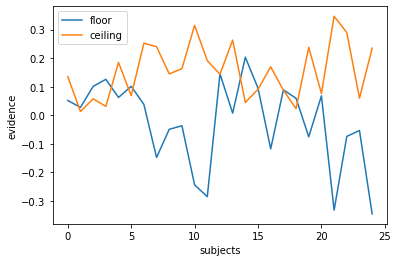

In [35]:
plt.plot(floors,label='floor')
plt.plot(ceilings,label="ceiling")
plt.legend()
plt.xlabel("subjects")
plt.ylabel("evidence")